## Overview of Time Series Forecasting from Statistical to ML and Recent DL Approaches 

Agenda:
- Introduction to TS
- Naive approaches
- Statistical
 - Smoothing techniques
 - ARIMA
- ML
  - Linear Regression
  - Decision Tree (XGBoost)
- DL 
 - LSTM, CNN
 - TCN
 - LSTNet
 - TFT 
 - N-BEATS
- Commercial:
 - Facebook Prophet
 - Amazon DeepAR
- Summary

# Time Series Forecasting


## Introduction

1. What is Time Series?
1. Example dataset
1. Components of Time Series
1. Forecasting Process: split data, metrics

**What is time series?**

Time series (TS) is a sequence of data that has some order in a set interval like time. It may not have be temporal, as long the data some ordering such as DNA sequences. 

**Time Series Analysis vs. Forecasting**

 - Analysis is interested in anlyzing and understanding of the time series to describe the pattern or its seasonality.
 - Forecasting is to predict the future value.

**Tasks involved in TS**
- EDA (Exploritory Data analysis): seasonality, nature of temporial process
- Prediction/Forecasting future values
- Classification type of TS
- Anomaly Detection

**Types of TS: Univariate vs. multivariate**
- univariate: time series with a single observation per time increments.
- multivariate: series has more than one time-dependent variables that capture the dynamic of multiple time series. 



### Dataset
- Air passengers: number of air passenger per month over 12 years (1949-1960) https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv
- Sunspot: monthly count of the number of observed sunspots for just over 230 years (1749-1983)
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv 
- Shampoo Sales: monthly sales of shampoo over a 3 year period (https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv)
- Milk production: avg monthly milk production (in lbs) of cows from Jan/1962 to Dec/1975. (https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv)


#### Multivariate Dataset
- Traffic : A collection of 48 months (2015-2016) hourly data
from the California Department of Transportation. The data
describes the road occupancy rates (between 0 and 1) measured by different sensors on San Francisco Bay area freeways.
- Solar-Energy: the solar power production records in the
year of 2006, which is sampled every 10 minutes from 137
PV plants in Alabama State.
- Electricity: The electricity consumption in kWh was recorded every 15 minutes from 2012 to 2014
- Exchange-Rate: the collection of the daily exchange rates of eight foreign countries including Australia, British, Canada from 1990 to 2016.

(https://github.com/laiguokun/multivariate-time-series-data)

#### Kaggle Tourism
- Part one requires competitors to predict 518 tourism-related time series. It contains 518 yearly time series. (https://www.kaggle.com/c/tourism1)
- Part two requires competitors to predict 793 tourism-related time series. It contains 793 time series. The first 366 columns contain monthly time series. The next 427 time series contain quarterly time series.  (https://www.kaggle.com/c/tourism2)

#### Makridakis Competitions: M3, M4
- M3: A total of 3003 time series was used.
- M4: 100,000 real-life series
https://mofc.unic.ac.cy/the-dataset/, https://github.com/Mcompetitions/M4-methods/tree/master/Dataset

In [32]:
# Loading Air Passenger Data

#Download data locally
!curl -O https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('AirPassengers.csv')
df.head(5)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1748  100  1748    0     0   8018      0 --:--:-- --:--:-- --:--:--  8055


Month  AirPassengers
0  1949-01            112
1  1949-02            118
2  1949-03            132
3  1949-04            129
4  1949-05            121

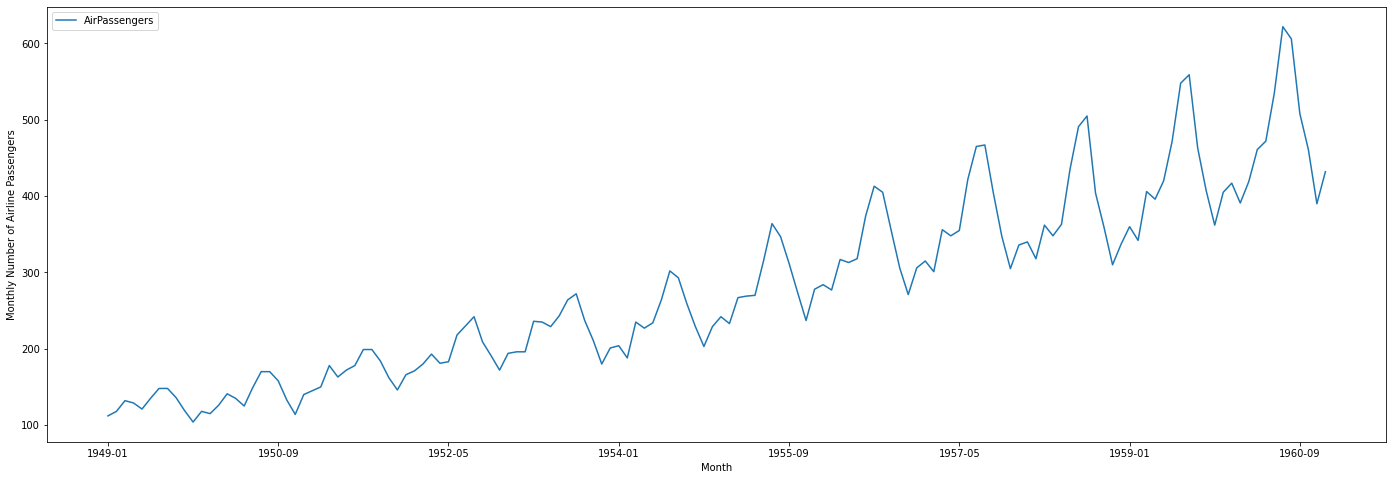

In [ ]:
ax = df.set_index('Month').plot(figsize=(24, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Month')
plt.show()

### Components of Time Series
**Classicla Decomposition**
A basic model for representing a time series:

$y_t = \mu_t + \gamma_t + \varepsilon_t$

where 
 - $y_t$ = observation,
 - $\mu_t$ = slowly changing component (trend),
 - $\gamma_t$ = periodic component (seasonality),
 - $\varepsilon_t$ = irregular component (noise).

Time series consists of:
 0. Level: local mean of the series
 1. Trend: estimate of the change between successive time points
 2. Seasonality: the deviation from the local mean due to seasonality
 3. Noise: residual components or random variation

$y_t = level + trend + seasonality + noise$

Ref:
- (State Space Time Series Analysis,
Siem Jan Koopman https://personal.vu.nl/s.j.koopman/documents/2011TSEweek1.pdf)*
- https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/



In [ ]:
# format data for time series
data = df
data.dtypes #Month object
data['Month'] = pd.DatetimeIndex(data['Month'])
df.dtypes   #Month datetime64[ns]

data.index  #RangeIndex(start=0, stop=144, step=1)
data = data.set_index('Month')
#data.index  #DatetimeIndex([...dtype='datetime64[ns]', name='Month', length=144, freq=None)

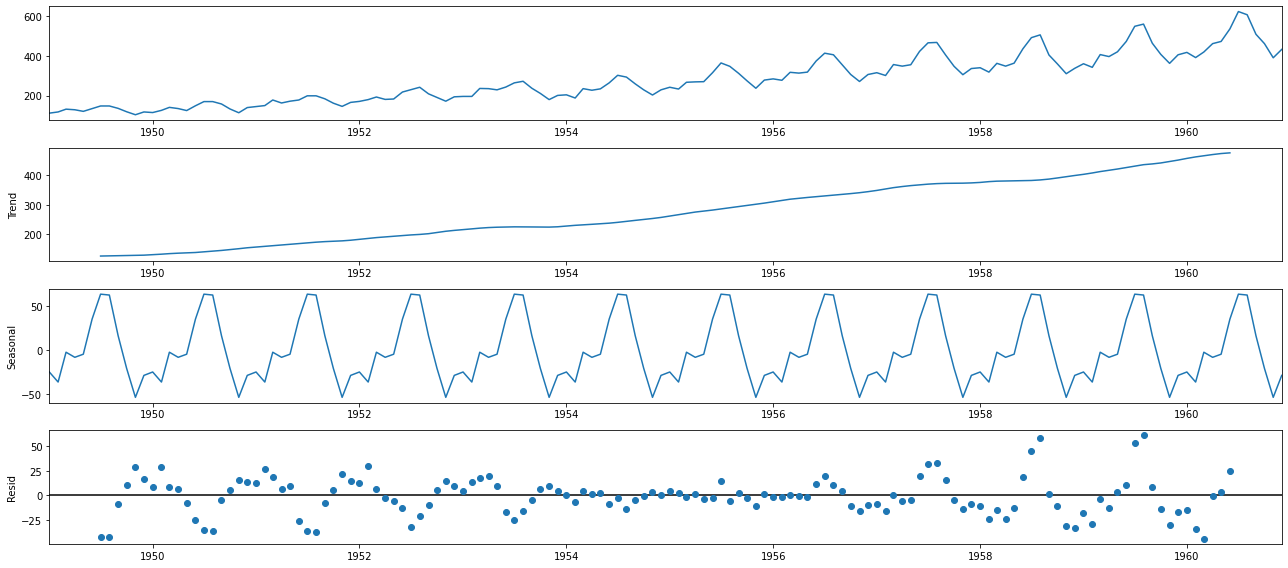

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive') #multiplicative, additive
fig = decomposition.plot()
plt.show()

### Predictions and Metrics


Before we can measure the performance we need to split our data into training and test set before running the experiment.

**Types of prediction**

We want to forecast into the future. There are two approaches of prediction:
 1. One-step ahead prediction
 2. Multi-horizons forecast
> 1. Iterated approaches: utilize one-step-ahead prediction and recursively feeding predictions into future inputs.
> 2. Direct approach: to explicitly generate predictions for multiple time steps at once.

**Univariate vs Multivariate Predictions**
- Some approaches can only model one time series and predict just one set of values.
- Some approaches can predict a single set of value from multivariate dataset.
- Some can predict multiple set of values from multivairate dataset.

**Train and Test Split**

So in our dataset, we want to train on earlier part of the dataset and left out the later part of the dataset to evaluate how well the model does. So we don't want to randomly split the dataset. 
- Training set: the first 80% of the data
- Test set: 20% of the latest part of the data, or predict last year or last month.
 
**Metrics**

To measue how well the algorithm perform, we'll choose one of the metrics below:
- MSE: Mean Squared Error = $\frac{\sum (\hat y - y) ^ 2}{n}$ <br/> `np.square(y_hat - y).mean()`
- RMSE: Root Mean Squared Error = `np.sqrt(MSE)`
- MAE: mean absolute error = $\frac{\sum |\hat y - y|}{n}$ <br/> `abs(y_hat - y).mean()`
- MAD: mean asbolute deviation = $\frac{\sum |\hat y_i - \bar y|}{n}$ <br/> `abs(y_hat - y.mean()).mean()`
- MAPE: mean absolute percentage error = $\frac{1}{n} \sum \frac{| y - \hat y |}{y} * 100 $ <br/>`(abs(y - y_hat) / y).mean() * 100`
- sMAPE: Symmetric mean absolute percentage error (scales the error by the average between the forecast and actual) = $\frac{\sum{| y - \hat y |}}{\sum{(y+\hat y)}} * 100$  <br/>
`abs(y - y_hat).sum/(y + y_hat).sum() * 100`
- MASE: Mean Absolute Scaled Error --scales by the average error of the naive null model
= $\frac{1}{n} \sum \frac{| \hat y - y |}{\frac{1}{T+n-m}\sum_j^{T+n} |y_{j} - y_{j-m}|}$ 
- OWA (overall weighted average) : M4-
specific metric used to rank competition entries (M4 Team, 2018b), where sMAPE and MASE metrics
are normalized such that a seasonally-adjusted naïve forecast obtains OWA = 1.0.

where 
> - $y$ : the ground truth observation value
> - $\hat y$ : predicted value 
> - $m$ : periodicity, 
> - $n$ : forecast horizon

## Generate Synthetic Data
To help understand the Trend, Seasonality and noise, what a better way then to generate the data ourselves.


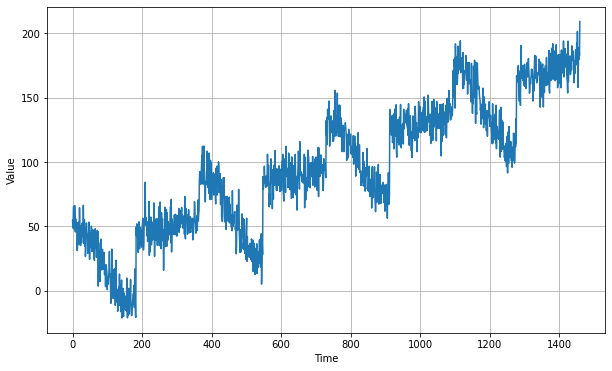

In [ ]:
#https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP_Week_1_Lesson_2.ipynb
import numpy as np
import matplotlib.pyplot as plt
  
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.5,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(2 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 10

# Create the series
series += baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plt.plot(time[0:], series[0:], "-")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [ ]:
series

array([ 52.48357 ,  49.48275 ,  53.574738, ..., 284.36185 , 281.42908 ,
       312.1077  ], dtype=float32)

## Decompose with FFT
“If you want to find the secrets of the universe, think in terms of energy, frequency and vibration.” ― Nikola Tesla

Fast Fourier Transform (FFT) decomposes signal from time domain into frequency domain.

A signal can be decomposed into a series of sine wave.


![time to frequency domain](https://miro.medium.com/max/471/1*uL4gqMutokf5r-M8P7bG7w.png)

*(https://towardsdatascience.com/fourier-transformation-and-its-mathematics-fff54a6f6659)*

Python FFT Libraries:
1. Fourier Transforms (**scipy.fft**): computes the one-dimensional discrete n-point discrete Fourier Transform (DFT) with the efficient Fast Fourier Transform (FFT) algorithm
2. Discrete Fourier Transform (**numpy.fft**): Compute the N-dimensional inverse discrete Fourier Transform.

Ref:
https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e

In [ ]:
y_orig = df["AirPassengers"] # 144 datapoint
y = y_orig[:100] # select just first 100 for training

n: 100


<StemContainer object of 3 artists>

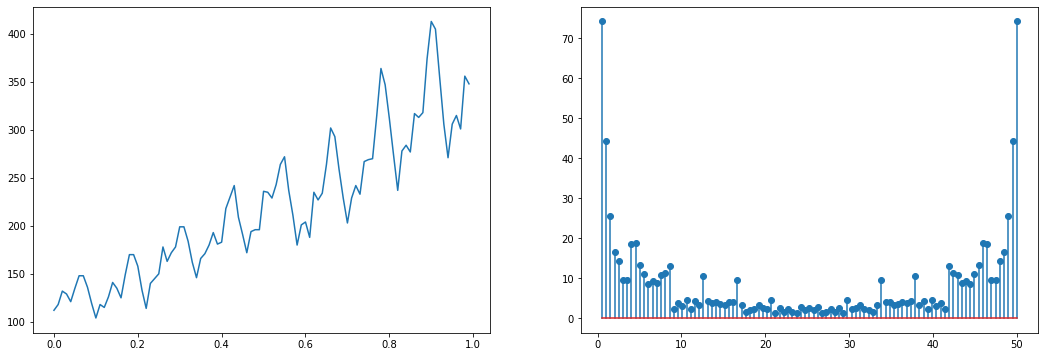

In [ ]:
# Perform Fourier transform using scipy
from scipy import fftpack
import numpy as np
# Frequency and sampling rate
f = 10 # frequency
Fs = 100 # sampling rate
t = np.arange(0,1,1/Fs)

# Sine function
#y = np.sin(2 * np.pi * f * t)

y_fft = fftpack.fft(y)
# Plot data
n = np.size(t)
print("n:",n)
fr = Fs/2 * np.linspace(0,1, int(n/1))
y_m = 2/n * abs(y_fft[0:np.size(fr)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].plot(t, y)    # plot time series
#ax[1].stem(fr, y_m) # plot freq domain -- remove 0 to see the detail
ax[1].stem(fr[1:], y_m[1:]) # plot freq domain -- remove 0 to see the detail

In [ ]:
fr_3 = fr[0:3]
y_m_3 = y_m[0:3]
print("fr:", fr_3)
print("y_m:", y_m_3)

fr: [0.         0.50505051 1.01010101]
y_m: [436.72        74.25173072  44.28864592]


n: 100
len of matchedf: 13 [21836.           -0.j           342.61652551+3696.74352699j
   113.01419543+2211.54655971j  -294.15053441+1247.37149191j
   -47.51269699 +819.33896138j     0.           +0.j
     0.           +0.j             0.           +0.j
  -204.51894881 -903.82755478j   522.19303723 +778.17705132j]


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


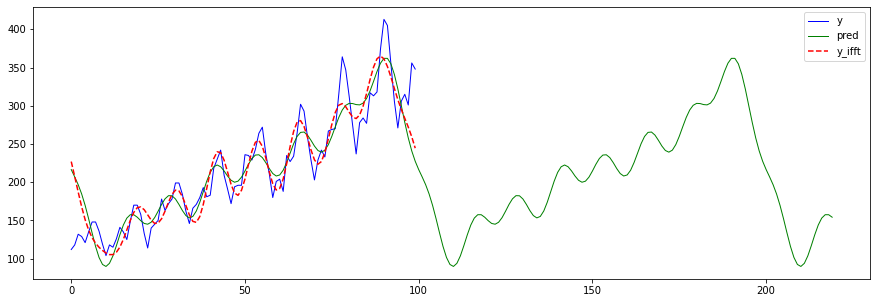

In [ ]:
# Inverse FFT from freq domain to original time domain
from scipy import fftpack
from numpy import fft
#print("len y_fft:", type(y_fft), len(y_fft), (y_fft[0:10]))

t = np.arange(0, 100)

#y_fft_cut = y_fft[0:99] #filter out a freq to see if it close match 
# try zero low amp freq (noise) -- didn't look just noise, no clear trend
treshold_amp = 16
y_fft_cut = np.zeros(y_fft.size, dtype=np.complex_)

n = np.size(t)
print("n:",n)
fr = Fs/2 * np.linspace(0,1, int(n/1))

matchedf = 0
y_m = 2/n * abs(y_fft[0:np.size(fr)])
for i, f in enumerate(y_fft):
  
  if y_m[i] > treshold_amp: 
    y_fft_cut[i] = f
    matchedf += 1
print("len of matchedf:", matchedf, y_fft_cut[0:10])

inv = fftpack.ifft(y_fft_cut, n=100)

# calculate the new data points from the FFT result
n_harm = 8
x_freqdom = y_fft_cut #y_fft
n=100
predsize2=220
f = fft.fftfreq(n)              # frequencies
indexes = list(range(n))
# sort indexes by frequency, lower -> higher
indexes.sort(key=lambda i: np.absolute(f[i]))

t2 = np.arange(0, predsize2)
res2 = np.zeros(t2.size)
for i in indexes[:1 + n_harm * 2]:
    ampli = np.absolute(x_freqdom[i]) / n   # amplitude
    phase = np.angle(x_freqdom[i])          # phase
    res2 += ampli * np.cos(2 * np.pi * f[i] * t2 + phase) 

plt.subplots(figsize=(15,5))
plt.plot(t, y, 'b', label = 'y', linewidth = 1)

plt.plot(np.arange(0, predsize2), res2, 'g', label = 'pred', linewidth = 1)

plt.plot(np.arange(0, inv.size), inv, 'r', label = 'y_ifft', linestyle="--")    # plot time series
plt.legend()
plt.show()

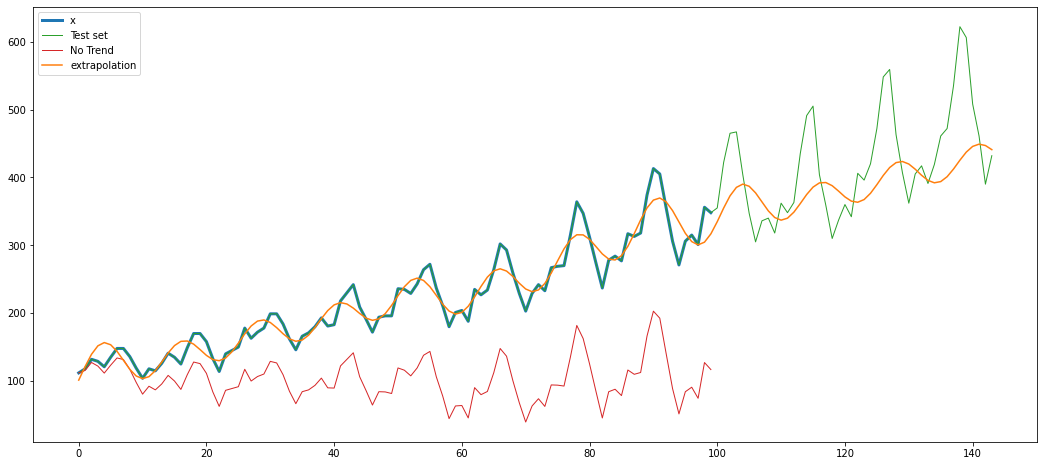

In [ ]:
#https://stackoverflow.com/questions/4479463/using-fourier-analysis-for-time-series-prediction
#https://gist.github.com/tartakynov/83f3cd8f44208a1856ce

import numpy as np
import pylab as pl
from numpy import fft

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 8                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x

    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return (restored_sig + p[0] * t, x_notrend)


x_orig = df["AirPassengers"] #144
x = x_orig[0:100]
n_predict = 44
(extrapolation, x_notrend) = fourierExtrapolation(x, n_predict)

pl.plot(np.arange(0, x.size), x, 'C0', label='x', linewidth=3)
pl.plot(np.arange(0, x_orig.size), x_orig, 'C2', label='Test set', linewidth=1)
pl.plot(np.arange(0, x.size), x_notrend, 'C3', label='No Trend', linewidth=1)

pl.plot(np.arange(0, extrapolation.size), extrapolation, 'C1', label='extrapolation')
pl.legend()
pl.show()

In [ ]:
# calculate MAE from 100-120
diff = np.abs(x_orig[100:120] - extrapolation[100:120])
diff.mean() #48.569

48.56931855957005

## Naive Approaches
We need a baseline approach so we can compare our fancy algorithms and see how well it does compare to the naive algorithms.




But first we need a way to measure how well an algorithm does. So let's go through different metric we can use.

- Null model: predict the next value as the previous one (persitence model)
- Seasonal Naive: give a season, the next value is same as previous season value
- Mean: take an average of all prevoius values as the forecast value
- Linear Trend: linear regression
- Random Walk: randomly add noise to prediction of previous value

Ref: https://medium.com/towards-artificial-intelligence/the-universe-of-time-series-forecasting-techniques-a-primer-f73011e18570


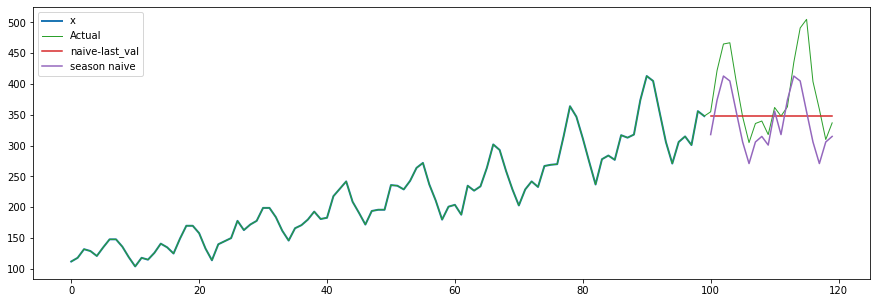

In [ ]:
# y[0:99], y_orig[0:144]
import numpy as np
import pylab as pl
from numpy import fft

x_orig = df["AirPassengers"][0:120] #144
x = x_orig[0:100]
extrapolation = np.zeros(20)
extrapolation += x[99]
seasonal = np.append(x[88:99],x[88:97])

plt.subplots(figsize=(15,5))
pl.plot(np.arange(0, x.size), x, 'C0', label='x', linewidth=2)
pl.plot(np.arange(0, x_orig.size), x_orig, 'C2', label='Actual', linewidth=1)
pl.plot(np.arange(100, 100+extrapolation.size), extrapolation, 'C3', label='naive-last_val')
pl.plot(np.arange(100, 100+seasonal.size), seasonal, 'C4', label='season naive')
pl.legend()
pl.show()

In [ ]:
# calculate MAE from 100-120
diff = np.abs(x_orig[100:120] - extrapolation[0:20])
#print("type diff:", type(diff)) #type diff: <class 'pandas.core.series.Series'>
naive_mae = diff.mean()
diff = np.abs(x_orig[100:120] - seasonal[0:20])
seasonal_mae = diff.mean()
print("Naive Last Val MAE:", naive_mae)
print("Seaonsal Naive MAE:", seasonal_mae)

Naive Last Val MAE: 49.95
Seaonsal Naive MAE: 45.6


## Smoothing
Smoothing with moving average to exponential smoothing is a way to filter out some of the noises in the data.

### Moving Average

**Simple Moving Average**

$y_t = (x_t + x_{t-1} + x_{t-2} + ... + x_{t-n-1})/n$

where $n$ is number of data point to smooth

```
pandas.DataFrame.mean()
pandas.DataFrame.rolling(n, center=False).mean()
```
Center and Trailing Moving Average

**Weighted Moving Average**

$y_t =  \cfrac{x_t * n + x_{t-1} * (n-1) + x_{t-2} * (n-2) + ... x_{t-n-1}} {\frac{n (n+1)}{2}}$


```
pandas.DataFrame.rolling(n).mean()
pandas.DataFrame.rolling(n, win_types='exponential').mean()
```

**Exponential Weighted Moving Average**

Simple Exponential Smoothing (Holt Linear)

$y_0=x_0$

$y_t = \alpha x_{t} + (1-\alpha)y_{t-1}$

- $\alpha$ : smoothing factor and $0<\alpha<1$ ; lower value means more smoothing 
- $y_t$ approximate over $\cfrac{1}{\alpha}$ data points 

ie. $\alpha$ = 0.5 ≈ 2 data points, 0.1 ≈ 10 data points, 0.02 ≈ 50 data points

```
pandas.DataFrame.ewm(alpha=0.12).mean()
```
$y_t=(1−α)y_{t−1}+αx_t$



Reference:
- Andrew Ng - Exponentially Weighted Averages (C2W2L03) https://www.youtube.com/watch?v=lAq96T8FkTw
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
- https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
- https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572

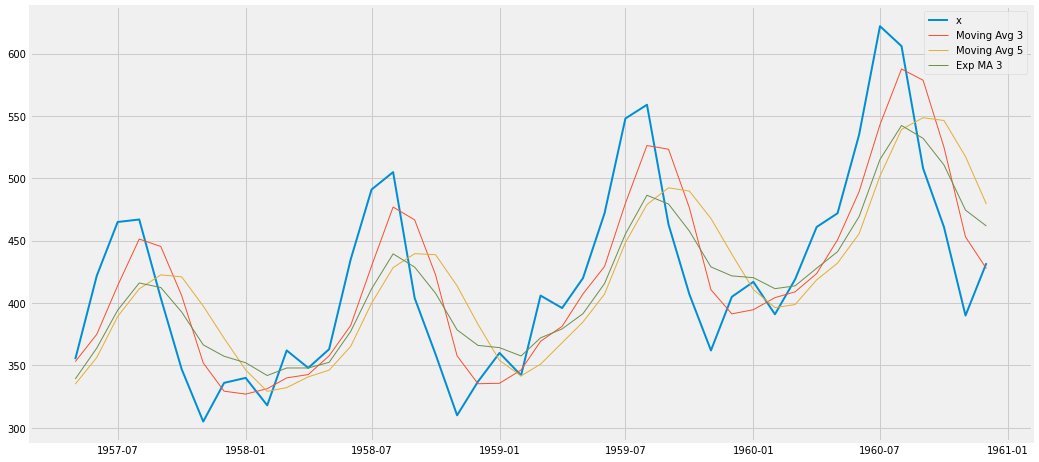

In [36]:
import pandas as pd
import pylab as pl
data = df
data.dtypes #Month object
data['Month'] = pd.DatetimeIndex(data['Month'])
df.dtypes   #Month datetime64[ns]

data.index  #RangeIndex(start=0, stop=144, step=1)
data = data.set_index('Month')
data.index  #DatetimeIndex([...dtype='datetime64[ns]', name='Month', length=144, freq=None)

ma1 = df.rolling(3).mean() #simple moving avg
#ma2 = df.rolling(10).mean()
ma2 = df.rolling(5).mean() 

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
expma = df.ewm(alpha=0.3).mean()

pl.subplots(figsize=(16,8))
pl.plot(data.index[100:], data[100:], 'C0', label='x', linewidth=2)
pl.plot(data.index[100:], ma1[100:], 'C1', label='Moving Avg 3', linewidth=1)
pl.plot(data.index[100:], ma2[100:], 'C2', label='Moving Avg 5', linewidth=1)
pl.plot(data.index[100:], expma[100:], 'C3', label='Exp MA 3', linewidth=1)

pl.legend()
pl.show()

### Exponenital Smoothing

**Linear Exponential Smoothing (Holt ES)**
- shown earlier as Exponential Weighted Moving Average
- Simple Exponential Smoothing

**Double Exponential Smoothing**
- Holt-Winters double exponential smoothing
- which handle trend at time t, as $b_t$ 

>$y_0 = x_0$

>$b_0 = x_1 - x_0$

$y_t = \alpha x_t + (1 - \alpha) (y_{t-1} + b_{t-1})$

$b_t = \beta(y_t - y_{t-1}) + (1-\beta)b_{t-1}$

where 
- $0\leq \alpha \leq 1$ : the data smoothing factor
- $0\leq \beta \leq 1$  : the trend smoothing factor

**Prediction:** $ y_{t+m} = y_t + b_tm $

&nbsp;

**Triple Exponential Smoothing (Holts-Winters ES)**
- Triple exponential smoothing (Holt Winters)
- Handle trend and seasonality where L is a cycle length

> $y_0 = x_0$

$y_t = \alpha \cfrac {x_t}{c_t -L} + (1 - \alpha) (y_{t-1} + b_{t-1})$

$b_t = \beta(y_t - y_{t-1}) + (1-\beta)y_{t-1}$

$c_t = \gamma \cfrac{x_t}{y_t} + (1-\gamma)c_{t-L}$

where 
- $0\leq \alpha \leq 1$ : the data smoothing factor,
- $0\leq \beta \leq 1$  : the trend smoothing factor
- $0\leq \gamma \leq 1$ : the seasonal change smoothing factor
- $L$ : cycle of seasonal change

**Prediction:** $y_{t+m} = (y_t + mb_t)c_{t-L+(m-1) \mod L}$

&nbsp;

References:

- https://en.wikipedia.org/wiki/Exponential_smoothing
- https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
- https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html
- https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html

In [ ]:
test = df[100:120]
train = df[0:100]

MAE moving_avg_forecast: 53.55
MAE SES: 51.8663576396004


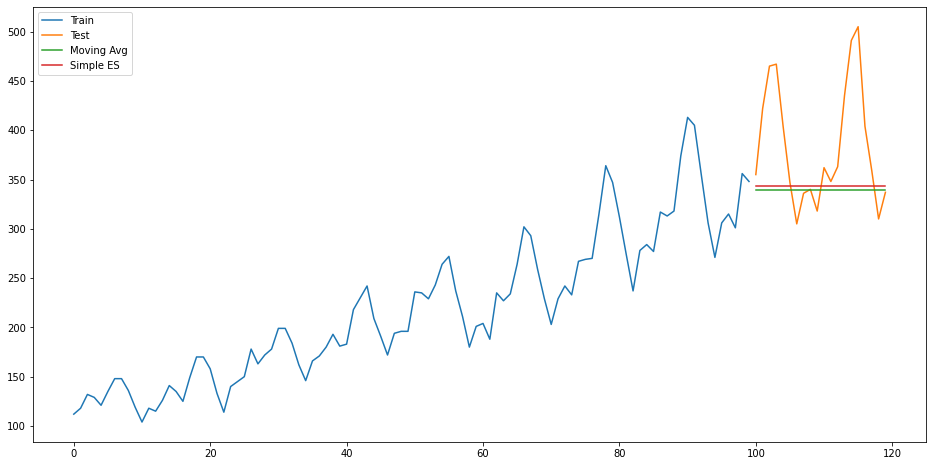

In [ ]:
# Predict using Moving Average 
# vs. Simple Exponential Smoothing (Holt ES)

#https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test
test = df[100:120]
train = df[0:100]

y_hat_avg['moving_avg_forecast'] = train['AirPassengers'].rolling(12).mean().iloc[-1]
diff = abs(y_hat_avg['moving_avg_forecast']  - test['AirPassengers'])
ma_mae = diff.mean()
print("MAE moving_avg_forecast:", ma_mae) #MAE moving_avg_forecast: 53.55

fit2 = SimpleExpSmoothing(np.asarray(train['AirPassengers'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))

diff = abs(y_hat_avg['SES']  - test['AirPassengers'])
ses_mae = diff.mean()
print("MAE SES:", ses_mae) #MAE SES: 51.86

plt.figure(figsize=(16,8))
plt.plot( train['AirPassengers'], label='Train')
plt.plot(test['AirPassengers'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Avg')
plt.plot(y_hat_avg['SES'], label='Simple ES')
plt.legend(loc='best')
plt.show()

MAE Holt_linear: 50.86160767242969
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  100
Model:             ExponentialSmoothing   SSE                          54525.414
Optimized:                         True   AIC                            638.125
Trend:                         Additive   BIC                            648.546
Seasonal:                          None   AICC                           639.028
Seasonal Periods:                  None   Date:                 Sat, 31 Oct 2020
Box-Cox:                          False   Time:                         02:06:30
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True

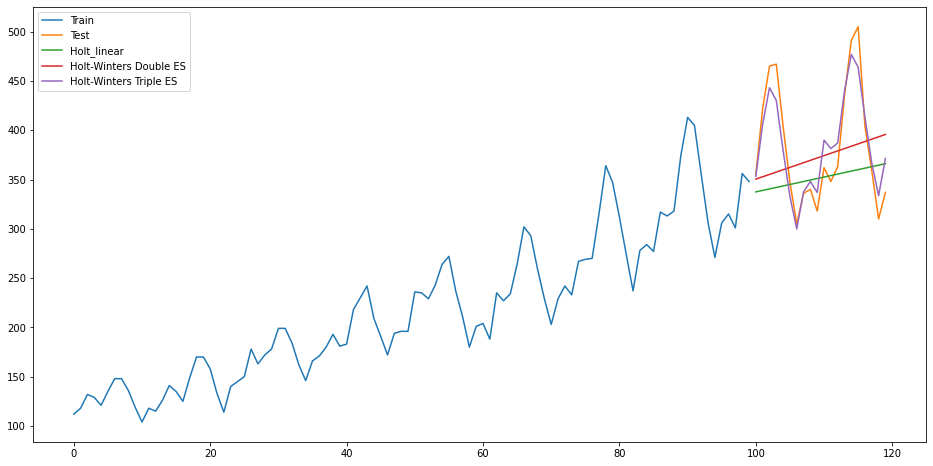

In [ ]:
# Holt Linear Smoothing vs. Holt-Winters
#https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
from statsmodels.tsa.api import Holt, ExponentialSmoothing

#Holt-Linear
fit1 = Holt(np.asarray(train['AirPassengers'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

diff = abs(y_hat_avg['Holt_linear']  - test['AirPassengers'])
holt_mae = diff.mean()
print("MAE Holt_linear:", holt_mae) #MAE Holt_linear: 50.86160767242969

#Holt-Winters - triple (trend='add', seaonsal=None)
model = ExponentialSmoothing(train["AirPassengers"], seasonal_periods=12, trend='add', seasonal=None)
fitted = model.fit()
print(fitted.summary())

forecast_trend = fitted.forecast(steps=20)


#Holt-Winters - triple (trend='add', seaonsal='add')
#https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
model = ExponentialSmoothing(train["AirPassengers"], seasonal_periods=12, trend='add', seasonal='add')
fitted = model.fit()
print(fitted.summary())

forecast = fitted.forecast(steps=20)

diff = abs(forecast - test['AirPassengers'])
hw_mae = diff.mean()
print("MAE Holt-Winter mult:", hw_mae) 
#MAE Holt-Winter mult: 16.328302652110207
#MAE Holt-Winter add: 18.441239762813538

plt.figure(figsize=(16,8))
plt.plot( train['AirPassengers'], label='Train')
plt.plot(test['AirPassengers'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.plot(forecast_trend, label='Holt-Winters Double ES')
plt.plot(forecast, label='Holt-Winters Triple ES')
plt.legend(loc='best')
plt.show()

## State Space Model (SSM)

SSMs model the temporal structure of the data via a latent state $l_t ∈ R^L$ that can be used to encode time series components such as level, trend, and seasonality patterns.



Known under several different names:
 - structural models (econometrics), 
 - dynamic linear models (statistics), 
 - Bayesian forecasting models (statistics), 
 - linear system models (engineering), 
 - Kalman filtering models (control engineering)

State space model (SSM) is based on a structural analysis of the problem that can be described by different components like trend, seasonality, cycle. These explanatory variable(s) are modeled separately then being put together in state space model.

"State space models provide a principled framework for modeling and learning time series patterns such as trend and seasonality. Prominent examples include ARIMA models
and exponential smoothing. SSMs are particularly well-suited for applications where the structure of the time series is well-understood, as they allow for the incorporation of structural assumptions into the model." (Rangapuram, NeurIPS 2018)

We will cover the follow algorithms:
1. ARIMA
2. Structural Time Series Model (STSM) or Unobserved Components Model (UCM)
 - Local Linear Trend Model
 - Smooth Trend Model
3. HMM

Ref:
- "Deep State Space Models for Time Series Forecasting" Amazon Research", Rangapuram, et al., NeurIPS 2018. (https://papers.nips.cc/paper/8004-deep-state-space-models-for-time-series-forecasting.pdf)
- https://towardsdatascience.com/state-space-model-and-kalman-filter-for-time-series-prediction-basic-structural-dynamic-linear-2421d7b49fa6)


### ARIMA Family
Classical Box-Jenkins methodology with ARIMA including AR, MA, ARMA, SARIMA, and SARIMAX. 

- There are other variances such as VAR (Vector Auto Regression), VARMA, and VARMAX. See link: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- Other approach like: ARCH and GARCH which handle change in variance. (https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/)


### ARMA

**AR** : Auto Regression -- uses the dependent relationship between an observation and some number of lagged observations.

Linear Regression using lag values as features. The lag $n$ value is the previous $n$ value. 
>- lag1 = $x_{n-1}$
>- lag2 = $x_{n-2}$

Paramer lags can be a number N or a list. For example: 
>- ``lags=3 `` is using lag1, lag2, lag3.
>- ``lags=[1,3]`` is using lag1, lag3.

**MA** : Moving Average -- uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The ARMA(1, 1) model is:

> - $y_t = \phi_1 y_{t-1} + \theta_1 \varepsilon_{t-1} + \varepsilon_t$
 - $\phi_1 y_{t-1}$: AR term
 - $\theta_1 \varepsilon_{t-1}$: MA term
> - Prediction: $\hat y_t = \phi_1 y_{t-1} + \theta_1 \varepsilon_{t-1}$ 

**Notations:**
ARMA(p,q)  where 
- p is the AR order and 
- q is the MA order

Ref:
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html
- http://www.chadfulton.com/topics/arma11_cpi_inflation.html
- https://www.youtube.com/watch?v=HhvTlaN06AM&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=8 (Time Series Talk : ARMA Model by ritvikmath June 2019)


### ARIMA

ARIMA is adding "I" to ARMA where:
- **I** : Integrated -- uses the differencing of raw observations in order to make the time series stationary. 

Differencing gives:
$z_t=y_{t+1} - y_t$

ARIMA: $z_t=\phi z_{t-1}+\theta \varepsilon_{t-1} + \varepsilon_t$
>reverse transform:
$y_t=\sum_{i=1}^{t-l} z_{t-i} + y_l$
where l is last time index

**Notations:**

- The ARIMA notation is ``ARIMA(p,d,q)`` 
where d is the order of integration, or number of differences. 
- ``ARMA(p,q)`` is equivalent to ``ARIMA(p,0,q)``

> - p: The number of lag observations included in the model, also called the **lag order**.
- d: The number of times that the raw observations are differenced, also called the **degree of differencing**.
- q: The size of the moving average window, also called the **order of moving average**.

Ref:
- https://www.quora.com/How-does-the-ARMA-model-differ-from-the-ARIMA-model-In-what-situation-is-the-ARMA-model-appropriate

### Test of Stationary
ARIMA works on stationary data. So we need the intergration(I) process to ensure the data is stationary.

Stationarity if all of the following conditions are true:
- mean ($\mu$) is constant 
- standard diviation ($\sigma$) is constant
- no seasonality

Check for stationarity:
- visually look at the chart
- do global vs local tests
- use Augmented Dickey-Fuller (ACF) test

Interpret ACF Result:
Using the p-value from the test:
 - p-value <= 0. 05 : stationary
 - p-value > 0. 05 : non-stationary

Make Stationary in integration process:
- use differencing: $z_t = y_t - y_{t-1}$
- may need second, third, or more differencing
- where $d$ value in ARIMA(p,d,q) is set

ACF vs PACF Test:
- ACF: Augmented Dickey-Fuller
 - MA - direct and indirect lags dependencies
- PACF: Partial Augmented Dickey-Fuller
 - AR - direct lags dependencies

Ref:
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8


ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


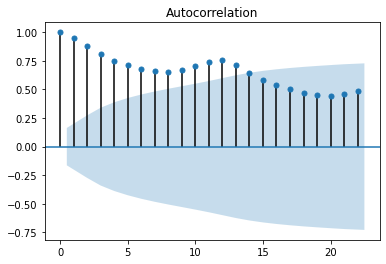

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
#data = read_csv('AirPassengers.csv', header=1, index_col=0) #load data first, don't need this

result = adfuller(data["AirPassengers"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

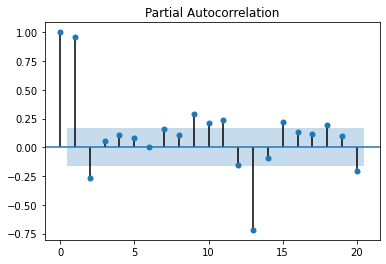

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, lags=20)
plt.show()

### ARIMA Prediction

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1748  100  1748    0     0   6909      0 --:--:-- --:--:-- --:--:--  6909


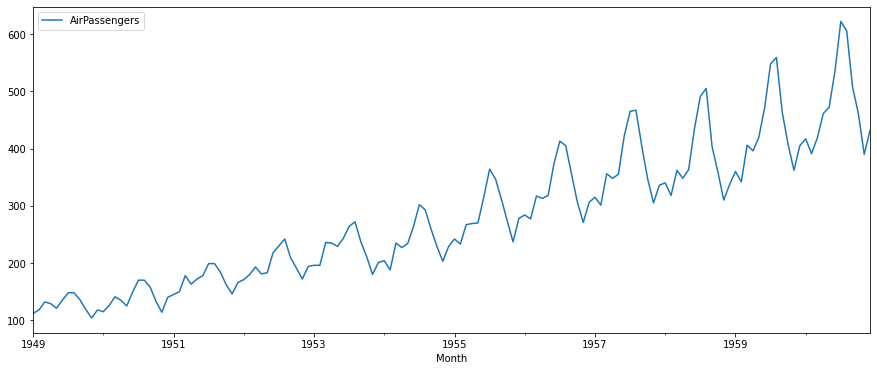

In [1]:
# @title 
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import warnings 
warnings.filterwarnings("ignore") 

# download data file
!curl -O https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv

df = pd.read_csv('AirPassengers.csv')
#df.head(5)

data = df
data.dtypes #Month object
data['Month'] = pd.DatetimeIndex(data['Month'])
df.dtypes   #Month datetime64[ns]

data.index  #RangeIndex(start=0, stop=144, step=1)
data = data.set_index('Month')
data.index  #DatetimeIndex([...dtype='datetime64[ns]', name='Month', length=144, freq=None)

#data["1960":]
data.plot(figsize=(15, 6))
plt.show()

AIC: 923.022, HQIC: 926.185, BIC: 930.837


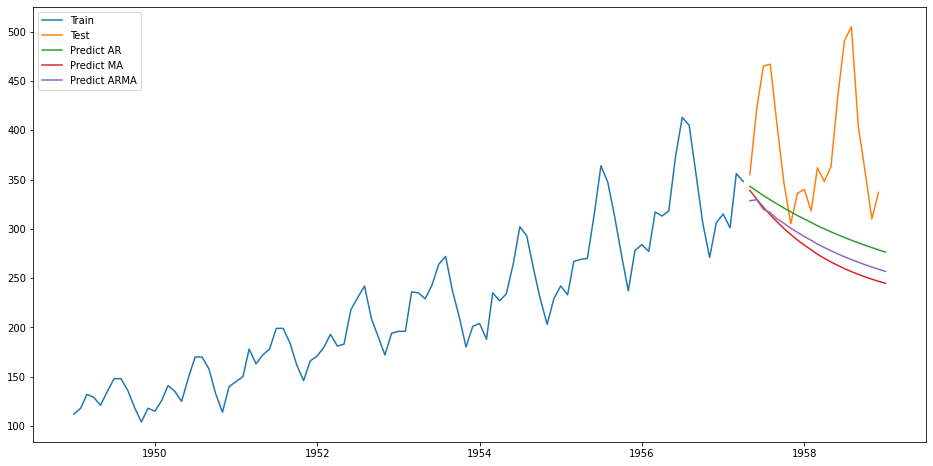

MAE AR: 77.8802038066285
MAE MA: 101.28020563340719
MAE ARMA: 93.89680858198498


In [ ]:
# ARMA model

from statsmodels.tsa.arima_model import ARMA
train = data[0:100]
test = data[100:120]

# fit model
model = ARMA(train, order=(1, 0)) # AR: p=1, q=0
model_fit = model.fit()

out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
print(out.format(model_fit.aic, model_fit.hqic, model_fit.bic))
#for lags=1  AIC: 6.351, HQIC: 6.383, BIC: 6.430
#for lags=6  AIC: 6.292, HQIC: 6.380, BIC: 6.509
#for lags=12 AIC: 5.132, HQIC: 5.291, BIC: 5.526
#for lags=24 AIC: 4.714, HQIC: 5.033, BIC: 5.512

model_ma = ARMA(train, order=(2, 0)) #ma: p=0, q=2
model_ma_fit = model_ma.fit(disp=False)

model_arma = ARMA(train, order=(2, 1))
model_arma_fit = model_arma.fit(disp=False)

# make prediction
yhat = model_fit.predict(len(train), len(train)+len(test))
yhat_ma = model_ma_fit.predict(len(train), len(train)+len(test))
yhat_arma = model_arma_fit.predict(len(train), len(train)+len(test))

plt.figure(figsize=(16,8))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(yhat, label='Predict AR')
plt.plot(yhat_ma, label='Predict MA')
plt.plot(yhat_arma, label='Predict ARMA')
plt.legend(loc='best')
plt.show()

MAE = abs(yhat - test['AirPassengers']).mean()
print("MAE AR:", MAE) # MAE AR: 67.07557715726492
MAE = abs(yhat_ma - test['AirPassengers']).mean()
print("MAE MA:", MAE) # MAE MA: 163.18050252340797
MAE = abs(yhat_arma - test['AirPassengers']).mean()
print("MAE ARMA:", MAE) # MAE ARMA: 88.6044333394646

#### ARIMA Parameters Search

In [ ]:
traindata = data[:-12] #data[0:100]
traindata.index
testdata = data[-12:] #data[100:120]
testdata.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [ ]:
# To install the library - to find hyper-parameter: p,d,q
# this is better performance then the custom grid search below, required restart -- uncomment below to use

#!pip install pmdarima

In [ ]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(data['AirPassengers'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 


In [ ]:
# Manual grid search
q = d = range(0, 2)
p=range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)
# solve ValueWarning: No frequency information was provided, so inferred frequency MS will be used.

In [ ]:
best_result = ""
best_aic = 9999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(traindata,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.aic < best_aic:
              best_aic = results.aic
              best_result = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
              print("Best so far result:", best_result)

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print("Best result:", best_result)
#ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:803.3627295936407

Best so far result: ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1853.867132204165
Best so far result: ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1575.2927100520799
Best so far result: ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1183.7768361260032
Best so far result: ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1039.368461271076
Best so far result: ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1018.1128824449078
Best so far result: ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1008.0082399525132
Best so far result: ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:999.1896494904968
Best so far result: ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:930.7565628459181
Best so far result: ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:925.377642181272
Best so far result: ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:919.7096064601092
Best so far result: ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:860.9989449358293
Best so far result: ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:829.7168124306302
Best so far result: ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:818.5774222837308
Best so far result: AR

#### Model

In [ ]:
#https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
mod = sm.tsa.statespace.SARIMAX(traindata,  
                order = (2, 1, 1),  # (0, 1, 1), 
                seasonal_order =(2, 1, 0, 12))  #(2, 1, 1, 12)) 

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5407      1.202     -0.450      0.653      -2.896       1.815
ar.L2         -0.0062      0.371     -0.017      0.987      -0.733       0.720
ma.L1          0.2889      1.214      0.238      0.812      -2.091       2.669
ar.S.L12      -0.0850      0.089     -0.952      0.341      -0.260       0.090
ar.S.L24       0.1516      0.101      1.508      0.132      -0.045       0.349
sigma2       104.7723     14.660      7.147      0.000      76.038     133.506


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       AirPassengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood                -446.018
Date:                             Fri, 23 Oct 2020   AIC                            904.036
Time:                                     00:14:43   BIC                            920.711
Sample:                                 01-01-1949   HQIC                           910.807
                                      - 12-01-1959                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5407      1.202     -0.450      0.653      -2.896       1.815
ar.L2         -0.0062      0.371     -0.017      0.987      -0.733       0.720
ma.L1          0.2889      1.214      0.238      0.812      -2.091       2.669
ar.S.L12      -0.0850      0.089     -0.952      0.341      -0.260       0.090
ar.S.L24       0.1516      0.101      1.508      0.132      -0.045       0.349
sigma2       104.7723     14.660      7.147      0.000      76.038     133.506
===================================================================================
Ljung-Box (Q):                       39.52   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.49   Prob(JB):                         0.81
Heteroskedasticity (H):               1.61   Skew:                            -0.09
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

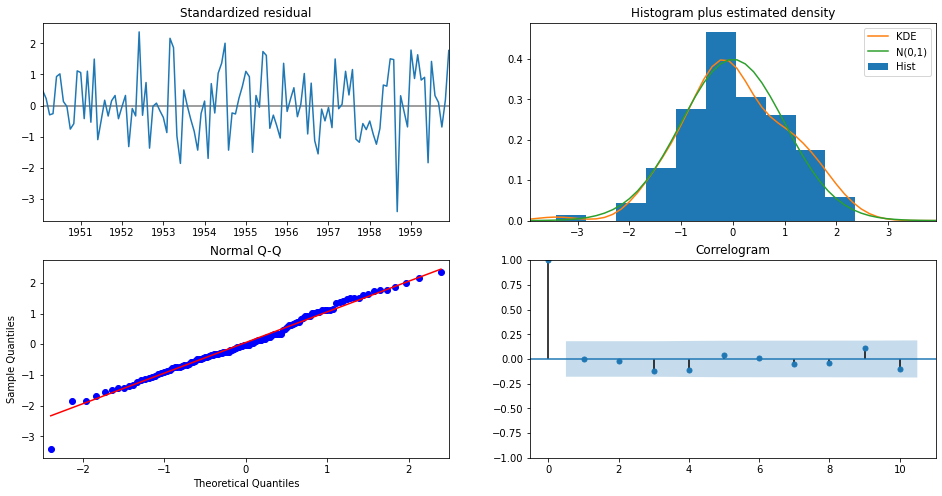

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
#pred_dynamic = results.get_prediction(start=pd.to_datetime('1960-07-01'),end=pd.to_datetime('1960-12-01'), dynamic=False, full_results=True)
pred = results.get_prediction(start=pd.to_datetime('1960-01-01'),end=pd.to_datetime('1960-12-01'), dynamic=False)
#pred = results.get_prediction(start=pd.to_datetime('1957-05-01'),end=pd.to_datetime('1958-12-01'), dynamic=False)

pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower AirPassengers  upper AirPassengers      result    y
1960-01-01           401.973665           442.097391  422.035528  417
1960-02-01           379.267100           429.378896  404.322998  391
1960-03-01           433.352729           494.611408  463.982069  419
1960-04-01           418.578914           487.914832  453.246873  461
1960-05-01           438.824559           516.019856  477.422208  472
1960-06-01           490.015762           574.033782  532.024772  535
1960-07-01           562.980045           653.457420  608.218732  622
1960-08-01           573.117980           669.548511  621.333245  606
1960-09-01           468.089006           570.163309  519.126157  508
1960-10-01           412.190332           519.593514  465.891923  461
1960-11-01           363.239984           475.729350  419.484667  390
1960-12-01           401.845668           519.196178  460.520923  432


In [ ]:
# calc performance
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

mae: 15.219111733354927
rmse: 19.536613678250486


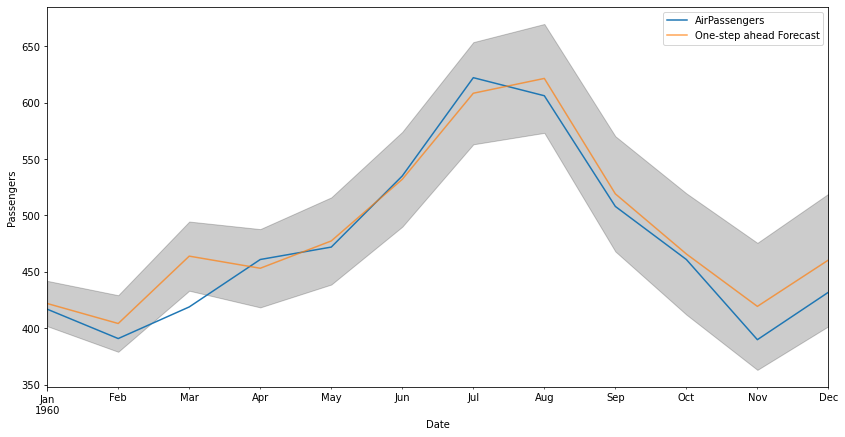

In [ ]:
pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()

plt.show()

In [ ]:
# compare to other source on the same dataset
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
rmse(pred_test["y"], pred_test["result"])  #18.38077757780352, same setup as url get: 17.1535

# compare to 17.1455 https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
#test set: one year(12 months) for testing, training set up the last 12 months

19.536613678250486

### Structural Model

Univariate unobserved components time series model

These are also known as structural time series models, and decompose a (univariate) time series into trend, seasonal, cyclical, and irregular components.

We will explore:
- local linear trend
- smooth trend

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html

In [ ]:
# code from: https://github.com/theJollySin/scipy_con_2019/blob/master/modern_time_series_analysis/ModernTimeSeriesAnalysis/StateSpaceModels/1_Structural_Time_Series_INSTRUCTOR.ipynb

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 6]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


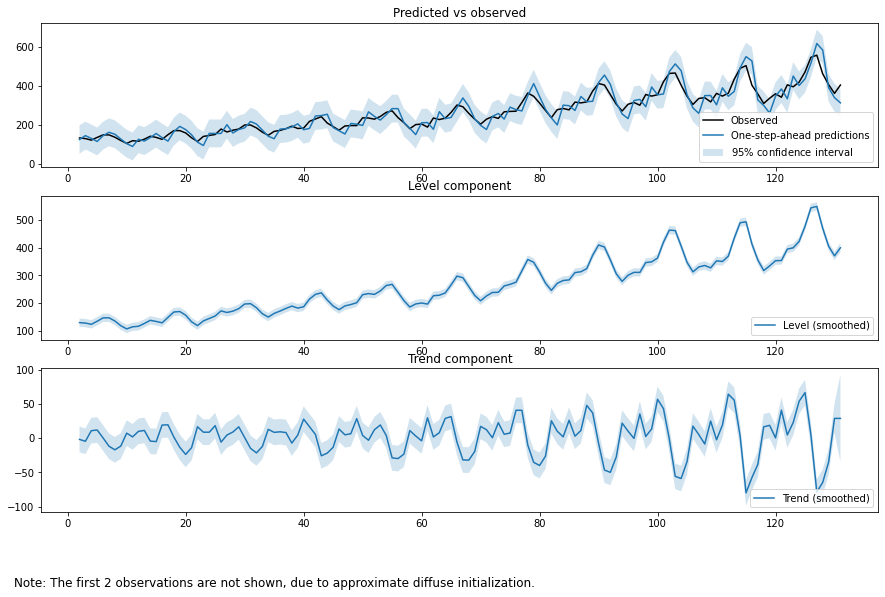

In [ ]:
train =  df[0:-12]

# smooth trend model without seasonal or cyclical components
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
gcag_mod = sm.tsa.UnobservedComponents(train['AirPassengers'], **model)
gcag_res = gcag_mod.fit()

fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));



In [ ]:
# Perform rolling prediction and multistep forecast
num_steps = 12
predict_res = gcag_res.get_prediction(dynamic=train['AirPassengers'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()
predict_res

55.55154893888224

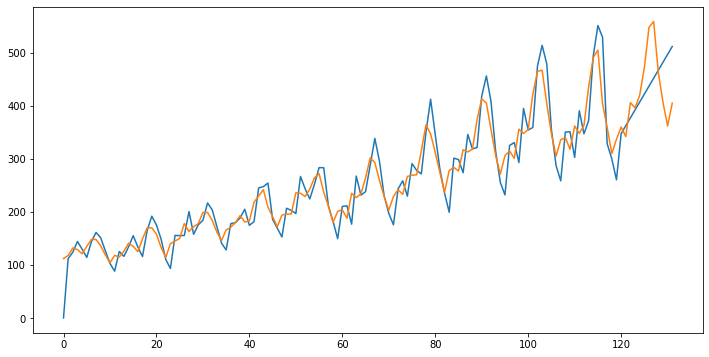

In [ ]:
matplotlib.rcParams['figure.figsize'] = [12, 6]
plt.plot(predict)
plt.plot(train['AirPassengers'])
maxidx=train['AirPassengers'].shape[0]
mae = abs(df['AirPassengers'][maxidx-12:maxidx].values - predict[maxidx-12:maxidx]).mean()
mae

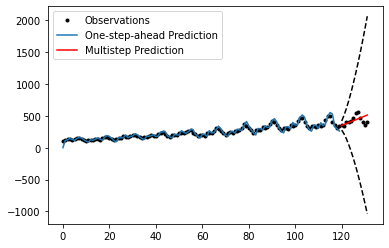

In [ ]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['AirPassengers'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

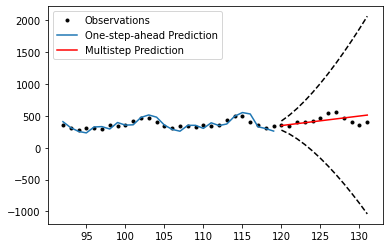

In [ ]:

fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['AirPassengers'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

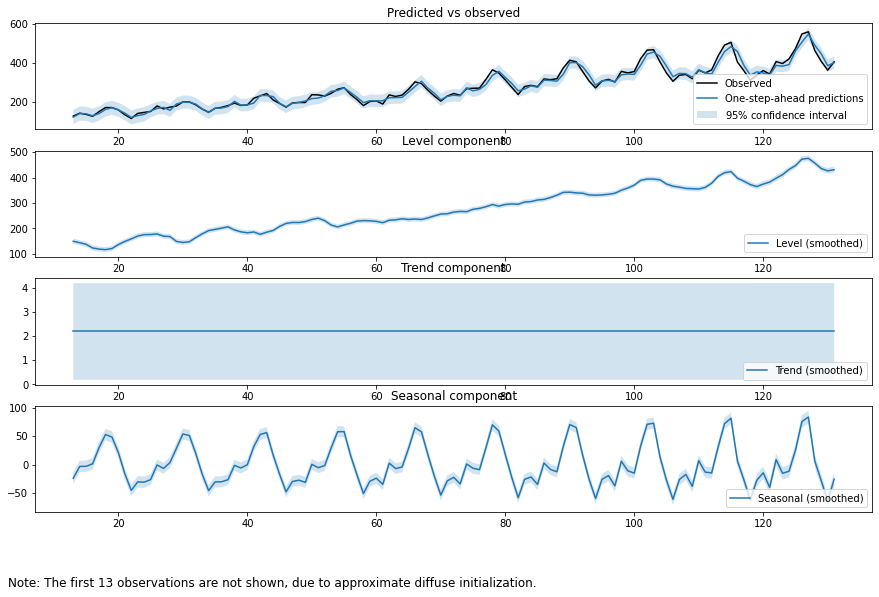

In [ ]:
# Add seasonal
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['AirPassengers'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [ ]:
num_steps = 12
predict_res = res.get_prediction(dynamic=train['AirPassengers'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

52.859554289152506

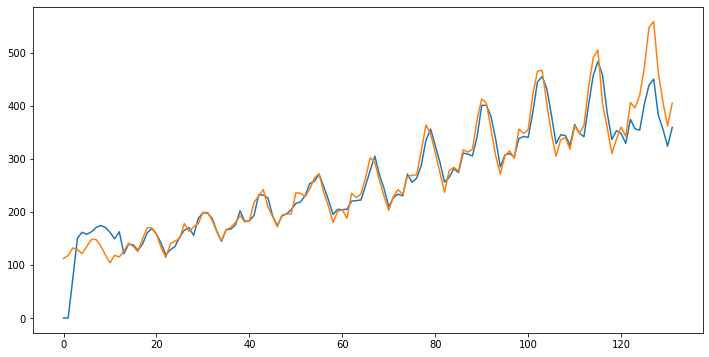

In [ ]:
matplotlib.rcParams['figure.figsize'] = [12, 6]
plt.plot(predict)
plt.plot(train['AirPassengers'])
#startidx=131
mae = abs(df['AirPassengers'][131-12:131].values - predict[131-12:131]).mean()
mae

### Hidden Markov Model

- State space - underlining state can't be observed but you can observe the output
- strutural: state and measure quantity are the same thing with error
- state space: give some kind of intuation and model of the underlying dynamic 
- Just need to know state at t-1, no other previous states


**HMM**

Show  evidence of the underlying dynamic or extraordinary state change

Does not apply here?
- where is the state transition matrix? prev price-> curr price (need to bucket it?)
- After modeling, the model can sample data-- predict
- Regime changes - can give better understanding to the data.

Parameter Estimation: Baum-Welch algorithm
- how to determine parameter
- use it when just knowing the states and nothing else 
- get maximum likelihood and update parameters - run several loops -- local max
- $\theta = (A, B, \pi)$ 
A:transistion matrix, B:matrix of lieklihood of x given y, $\pi$:prior
- forward step: the probability of seeing the observations $y_{1},y_{2},\ldots ,y_{t}$ and being in state t
- backward: the probability of the ending partial sequence $y_{t+1},\ldots ,y_{T}$ given starting state  i at time  t

Smoothing/state labeling:  Viterbi algorithm



In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 368kB 5.3MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmmlearn

from hmmlearn.hmm import GaussianHMM

In [ ]:
#https://github.com/theJollySin/scipy_con_2019/blob/master/modern_time_series_analysis/ModernTimeSeriesAnalysis/StateSpaceModels/2_Gaussian_HMM_INSTRUCTOR.ipynb
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    # re-order parameters in ascending order of mean of underlying distribution
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]
    return (relabeled_states, mus, sigmas, transmat, model)

In [ ]:
train = data[0:100]
test = data[100:120]
hidden_states, mus, sigmas, transmat, model = fitHMM(train, 4)


[237.5500853  183.52304868 314.29513515 134.30838131]
[17.83905309 15.39107255 42.44486021 17.08013322]


In [ ]:
def plot_states(ts_vals, states, time_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('AirPassenger',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

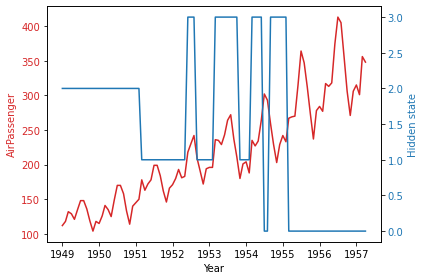

In [ ]:
plot_states(train, hidden_states, train.index)

In [ ]:
# can use sample to predict????
res = np.squeeze(model.sample(1000)[0])
plt.plot(res, label='Predict ARMA')
plt.legend(loc='best')
plt.show()

### Deep State Space Models
There are a few model related to state space approach inclding DSSM and DMM that won't cover here. See below links for detail.
- Deep State Space Models (DSSM) for Time Series Forecasting", Syama Rangapuram, Matthias Seeger, et. al., NeurIps 2018. (https://papers.nips.cc/paper/8004-deep-state-space-models-for-time-series-forecasting.pdf
- Deep Markov Model (DMM) -- Rahul G Krishnan, Uri Shalit, and David Sontag. Deep kalman filters. arXiv preprint
arXiv:1511.05121, 2015


## ML: Classical Approaches
ML approaches was not developed specifically for time series, but we can make it accept time series data. Other models earlier was develop for temporal data/time series on their cores. We'll explore basic supervise learning techniques:

- Linear Regression
- Decision Tree with XGBoost (Gradient Boosted Tree) - showed great performance within Kaggle community


![](https://ars.els-cdn.com/content/image/1-s2.0-S157401372030071X-gr3.jpg)


### Generating Features
In earlier statistical approaches like ARIMA, the system was built for time series data. For ML, we need to generate features that the ML algorithms can use. Some of the features include:
- lags : value at time step t-N
- amplitude: amplitude from the mean value
- max/min value: max or min value at that window
- value > 1 std : count of value great than 1 standard deviation

![auto features gen](https://github.com/blue-yonder/tsfresh/raw/main/docs/images/introduction_ts_exa_features.png)

There is a library [cesium](https://github.com/cesium-ml/cesium) that provides features generation.


**We will just use lags values for our features.**



In [ ]:
# Generate lags features

#https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import concat

 
# transform a time series dataset into a supervised learning dataset
def gen_features(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# example feature gen
x = [x for x in range(0,20)]
print("Time series:", x)
f = gen_features(x, n_in=12, dropnan=False)
f


Time series: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  1.,  2.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  1.,  2.,  3.],
       [nan, nan, nan, nan, nan, nan, nan, nan,  0.,  1.,  2.,  3.,  4.],
       [nan, nan, nan, nan, nan, nan, nan,  0.,  1.,  2.,  3.,  4.,  5.],
       [nan, nan, nan, nan, nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [nan, nan, nan, nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [nan, nan, nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [nan, nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 1.,  2.,  3.,  4.,  5.,  6., 

### Linear Regression

In [ ]:
# https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
from pandas import read_csv
from sklearn import linear_model

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an linear_reg_forecast model and make a one step prediction
def linear_reg_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	model = linear_model.LinearRegression()
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = linear_reg_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

>expected=417.0, predicted=395.3
>expected=391.0, predicted=393.8
>expected=419.0, predicted=424.9
>expected=461.0, predicted=423.5
>expected=472.0, predicted=488.1
>expected=535.0, predicted=506.1
>expected=622.0, predicted=612.7
>expected=606.0, predicted=607.8
>expected=508.0, predicted=532.1
>expected=461.0, predicted=439.6
>expected=390.0, predicted=422.5
>expected=432.0, predicted=421.8
MAE: 17.688


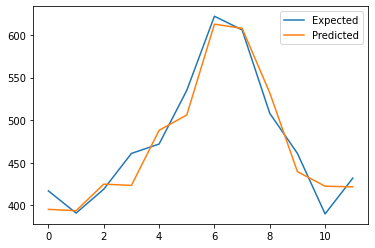

In [ ]:
# load the dataset
series = read_csv('AirPassengers.csv', header=0, index_col=0)
values = series.values

# transform the time series data into supervised learning
data = gen_features(values, n_in=12)

# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae) # MAE: 25.608
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### XGBoost

In [ ]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=500) #1000
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

>expected=417.0, predicted=384.8
>expected=391.0, predicted=403.8
>expected=419.0, predicted=459.7
>expected=461.0, predicted=437.5
>expected=472.0, predicted=465.7
>expected=535.0, predicted=506.3
>expected=622.0, predicted=550.9
>expected=606.0, predicted=617.6
>expected=508.0, predicted=494.8
>expected=461.0, predicted=457.5
>expected=390.0, predicted=452.8
>expected=432.0, predicted=431.4
MAE: 25.584


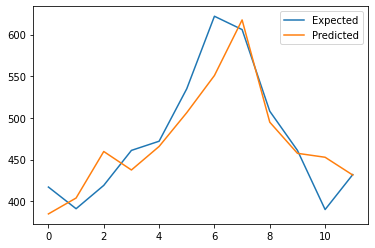

In [ ]:
# load the dataset
series = read_csv('AirPassengers.csv', header=0, index_col=0)
values = series.values

# transform the time series data into supervised learning
data = gen_features(values, n_in=12)

# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae) # MAE: 25.608
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Deep Learning


**Convolutional Neural Network (CNN)**

1. Causual Convolution

> $h_t^{l+1} = A(\sum\limits_{\tau=0}^k{W(l,\tau)h_{t-\tau}^l}$
- $h_t^l$ : hidden state at layer $l$ at time $t$
- $W(l,\tau)$: filter weight at layer {l}
- $A$: activation function like sigmoid or relu

2. Dilated Convolution: Dilated convolutions can hence
be interpreted as convolutions of a down-sampled version of the lower layer features – reducing
resolution to incorporate information from the distant past. As such, by increasing the dilation rate
with each layer, dilated convolutions can gradually aggregate information at different time blocks,
allowing for more history to be used in an efficient manner.

> $h_t^{l+1} = A(\sum\limits_{\tau=0}^{\lfloor{k/d_l}\rfloor}{W(l,\tau)h_{t-\tau}^l}$
- $d_l$ dilation rate on specific layer

**Recurrent Neural Network (RNN)**

RNN used as sequence modeling for NLP. It has internal state that summarize the past information and get recursivel udpate with new data at each time step.

- use in sequence modeling  in NLP
- add memory cell in LSTM

> $y_{t+1} = \gamma_y(W_y x_t + b_y)$
> $z_t = \gamma_z ( W_{z_1} z_{t-1} + W_{z_2}y_t + W_{z_3} x_t + W_{z_4}s + b_z )$
- $z_t$: hidden state at time $t$
- $W, b$: linear weigths and biases
- $\gamma$: activation function

**Long Short-Term Memory (LSTM)**

> $z_t = o_t \odot \tanh(c_t)$
- $o_t$: output gate,
- $c_t$: cell state that includes $z_t$

**Attention Mechanisms**

Improvement in long term dependcency learning in NLP. It aggregates temporal features using dynamically genterated weights allow the network to focus on significat time steps in the past in ven far back look back window. Using key-value lookup for a query $q$:

> $h_t = \sum\limits_{\tau=0}^k{\alpha(k_t, q_\tau)v_{t-\tau}}$

> - $k_t$: key
> - $q_\tau$: query
> - $v_{t-\tau}$: intermediate features produced at different time steps
> - $\alpha(k_t,q_\tau)$ : attention weight at time $t$

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/02d49b4dbaf8c093034918a76648fea53961753d/2-Figure1-1.png)
Figure 1: Incorporating temporal information using different encoder architectures. <br/>

*("Time Series Forecasting With Deep Learning: A Survey",
Bryan Lim, Stefan)*



### LSTM
Long Short-Term Memory

In [37]:
#https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%204%20-%20LSTM.ipynb

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

import csv
time_step = []
airpass = []

with open('AirPassengers.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i=0
  for row in reader:
    airpass.append(float(row[1]))
    time_step.append(i)
    i+=1

series = np.array(airpass)
time = np.array(time_step)
#plt.figure(figsize=(10, 6))
#plot_series(time, series)   

In [61]:
split_time = 130
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 24
batch_size = 24
shuffle_buffer_size = 100

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=120, callbacks=[lr_schedule])

Epoch 1/120
5/5 [==============================] - 0s 22ms/step - loss: 244.4722 - mae: 244.9722
Epoch 2/120
5/5 [==============================] - 0s 26ms/step - loss: 244.4333 - mae: 244.9333
Epoch 3/120
5/5 [==============================] - 0s 20ms/step - loss: 244.3742 - mae: 244.8742
Epoch 4/120
5/5 [==============================] - 0s 20ms/step - loss: 244.3028 - mae: 244.8028
Epoch 5/120
5/5 [==============================] - 0s 20ms/step - loss: 244.2215 - mae: 244.7215
Epoch 6/120
5/5 [==============================] - 0s 22ms/step - loss: 244.1298 - mae: 244.6298
Epoch 7/120
5/5 [==============================] - 0s 21ms/step - loss: 244.0275 - mae: 244.5275
Epoch 8/120
5/5 [==============================] - 0s 25ms/step - loss: 243.9129 - mae: 244.4129
Epoch 9/120
5/5 [==============================] - 0s 19ms/step - loss: 243.7849 - mae: 244.2849
Epoch 10/120
5/5 [==============================] - 0s 21ms/step - loss: 243.6423 - mae: 244.1422
Epoch 11/120
5/5 [===========

(1e-08, 0.0001, 0.0, 300.0)

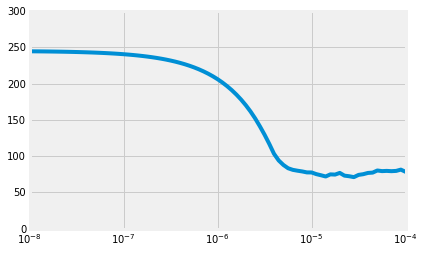

In [63]:
# find learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 300])

In [71]:
tf.keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=200,verbose=1)

Epoch 1/200
5/5 [==============================] - 0s 27ms/step - loss: 373647.5625 - mae: 495.5134
Epoch 2/200
5/5 [==============================] - 0s 23ms/step - loss: 29256.6484 - mae: 138.1454
Epoch 3/200
5/5 [==============================] - 0s 24ms/step - loss: 14476.6016 - mae: 101.5671
Epoch 4/200
5/5 [==============================] - 0s 24ms/step - loss: 11284.5400 - mae: 82.5523
Epoch 5/200
5/5 [==============================] - 0s 27ms/step - loss: 9848.6162 - mae: 80.6167
Epoch 6/200
5/5 [==============================] - 0s 24ms/step - loss: 9813.7832 - mae: 83.6348
Epoch 7/200
5/5 [==============================] - 0s 25ms/step - loss: 10266.2764 - mae: 80.9372
Epoch 8/200
5/5 [==============================] - 0s 24ms/step - loss: 9293.4238 - mae: 79.8863
Epoch 9/200
5/5 [==============================] - 0s 31ms/step - loss: 9450.0479 - mae: 81.1028
Epoch 10/200
5/5 [==============================] - 0s 27ms/step - loss: 9782.9102 - mae: 80.1412
Epoch 11/200
5/5 [==

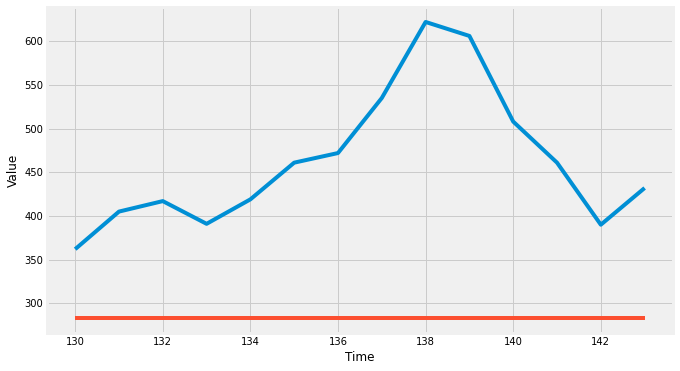

In [67]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

190.33916

### CNN + LSTM

1D Conv + LSTM: 
Adding convolution of the input and generate as features inputs the the LSTM.

https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%205.ipynb#scrollTo=tP7oqUdkk0gY



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

import csv
time_step = []
airpass = []

with open('AirPassengers.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i=0
  for row in reader:
    airpass.append(float(row[1]))
    time_step.append(i)
    i+=1

series = np.array(airpass)
time = np.array(time_step)
#plt.figure(figsize=(10, 6))
#plot_series(time, series)   

In [ ]:
split_time = 130
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 12
batch_size = 24
shuffle_buffer_size = 48

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(130,)
Epoch 1/100
1/1 [==============================] - 0s 10ms/step - loss: 234.3813 - mae: 234.8813
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 234.3429 - mae: 234.8429
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 234.2650 - mae: 234.7650
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 234.1466 - mae: 234.6466
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 233.9856 - mae: 234.4856
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 233.7798 - mae: 234.2798
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 233.5264 - mae: 234.0264
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 233.2216 - mae: 233.7216
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 232.8615 - mae: 233.3615
Epoch 10/100
1/1 [================

(1e-08, 0.0001, 0.0, 260.0)

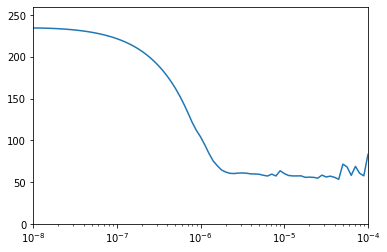

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 260])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

#1D conv + LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.95) #lr:e-5 -> e-6, mom 0.9 ->0.95
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 7ms/step - loss: 263.5536 - mae: 264.0536
Epoch 2/500
1/1 [==============================] - 0s 1ms/step - loss: 242.8308 - mae: 243.3308
Epoch 3/500
1/1 [==============================] - 0s 1ms/step - loss: 217.5935 - mae: 218.0935
Epoch 4/500
1/1 [==============================] - 0s 2ms/step - loss: 206.3515 - mae: 206.8515
Epoch 5/500
1/1 [==============================] - 0s 1ms/step - loss: 198.7296 - mae: 199.2296
Epoch 6/500
1/1 [==============================] - 0s 1ms/step - loss: 191.7370 - mae: 192.2370
Epoch 7/500
1/1 [==============================] - 0s 1ms/step - loss: 184.0305 - mae: 184.5305
Epoch 8/500
1/1 [==============================] - 0s 1ms/step - loss: 175.6320 - mae: 176.1320
Epoch 9/500
1/1 [==============================] - 0s 2ms/step - loss: 166.4230 - mae: 166.9230
Epoch 10/500
1/1 [==============================] - 0s 1ms/step - loss: 155.9799 - mae: 156.4798
Epoch 11/500
1/1 [=====================

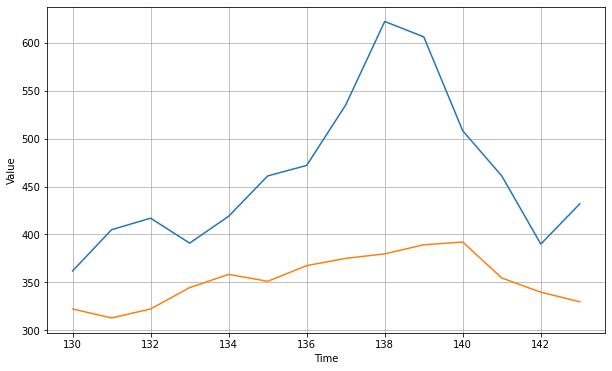

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() #143->121 change learning rate from -e5 to e6
# momen for 0.9 -> 0.95 => loss=86.8

110.03573

<Figure size 432x288 with 0 Axes>

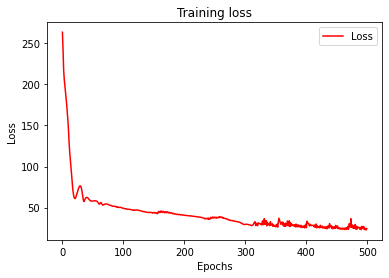

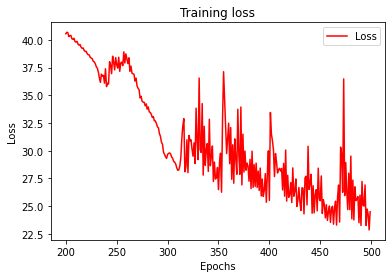

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

### TCN


Temporal Convolutional Networks, or simply TCN, is a variation of Convolutional Neural Networks for sequence modelling tasks, by combining aspects of RNN and CNN architectures. 

This model performance a multi-horizon prediction.


TCN is based upon two principles:
- the fact that the network produces an output of the same
length as the input, and 
- the fact that there can be no leakage
from the future into the past. To accomplish the first point,
the TCN uses a 1D fully-convolutional network (FCN) architecture.

![tcn](https://images4.pianshen.com/786/83/83d5f6e1a25df286f5ebec9f977b4912.png)

![result](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/921196c32213a229245a9705ee4768bc941e7a26/6-Table1-1.png)

TCN implementations for different ML libraries can be found here: 

- Pytorch: http://github.com/locuslab/TCN
- Keras: https://github.com/philipperemy/keras-tcn
- Tensorflow: https://github.com/Baichenjia/Tensorflow-TCN

Ref:
- "An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling", Shaojie Bai, J. Zico Kolter, Vladlen Koltun (https://arxiv.org/abs/1803.01271)
- https://towardsdatascience.com/farewell-rnns-welcome-tcns-dd76674707c8
- https://dida.do/blog/temporal-convolutional-networks-for-sequence-modeling





**KDTCN (Knowledge Driven TCN)**

Knowledge-Driven Stock Trend Prediction and Explanation via
Temporal Convolutional Network

![](https://miro.medium.com/max/500/1*av3j_IHrU1ACgDBq2NLstA.png)

Ref:
- https://core.ac.uk/download/pdf/222446995.pdf


In [ ]:
!pip install keras-tcn

     |████████████████████████████████| 378kB 4.9MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

from tcn import TCN, tcn_full_summary

batch_size, timesteps, input_dim = None, 20, 1


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train


i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False)(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

tcn_full_summary(m, expand_residual_blocks=False)

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl [(None, 20, 64), (None, 2 8576      
_________________________________________________________________
residual_block_1 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
residual_block_2 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
residual_block_3 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
residual_block_4 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
residual_block_5 (ResidualBl [(None, 20, 64), (None, 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tcn import TCN

d = pd.read_csv('AirPassengers.csv', index_col=0, parse_dates=True)

lookback_window = 12  # months.

d = d.values  # just keep np array here for simplicity.

x, y = [], []
for i in range(lookback_window, len(d)):
    x.append(d[i - lookback_window:i])
    y.append(d[i])
x = np.array(x)
y = np.array(y)

x_train = x[0:-12]
y_train = y[0:-12]
x_test = x[-12:]
y_test = y[-12:]
print(x.shape)
print(y.shape)

i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])

model.summary()

model.compile('adam', 'mae')

print('Train...')
model.fit(x_train, y_train, epochs=150, verbose=0)
print('done', model.losses)

(132, 12, 1)
(132, 1)
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 12, 1)]           0         
_________________________________________________________________
tcn_12 (TCN)                 (None, 64)                91136     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 91,201
Trainable params: 91,201
Non-trainable params: 0
_________________________________________________________________
Train...
done []


MAE: 15.013376871744791


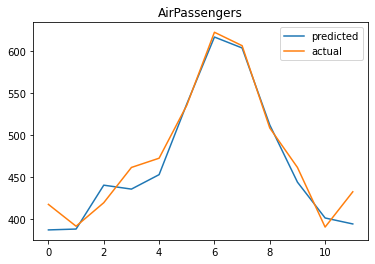

In [ ]:
p = model.predict(x_test)
mae = abs(p-y_test).mean()
print("MAE:",mae) #MAE: 15.013376871744791
plt.plot(p)
plt.plot(y_test)
plt.title('AirPassengers')
plt.legend(['predicted', 'actual'])
plt.show()

### LSTNet
Long- and Short-Term Temporal Network ([LSTNet](https://arxiv.org/pdf/1703.07015.pdf))



Multivariate time series forecasting often faces a major research
challenge, that is, how to capture and leverage the dynamics dependencies among multiple variables.

Short coming of classical ARIMA:
- ARIMA models are adaptive to various
exponential smoothing techniques and flexible enough to
subsume other types of time series models. However, ARIMA models, are rarely used in
high dimensional multivariate time series forecasting.
- vector autoregression (VAR) is arguably the
most widely used models in multivariate time series due
to its simplicity. The model capacity of VAR grows
linearly over the temporal window size and quadratically over the number of variables. 

![LSTNet](https://raw.githubusercontent.com/opringle/multivariate_time_series_forecasting/master/docs/model_architecture.png)

LSTNet Components:
 1. CNN with k-th filter with RELU
 2. RNN (GRU) - with RELU
 3. RNN Skip Connection
 4. Temporal Attention Layer
 5. Autogression with highway

Ref:
- https://modelzoo.co/model/lstnet
- https://opringle.github.io/2018/01/05/deep_learning_multivariate_ts.html
- "Modeling Long- and Short-Term Temporal Patterns with Deep Neural Networks", Lai et al., SIGIR 2018
(https://arxiv.org/pdf/1703.07015.pdf )
Code: https://github.com/laiguokun/LSTNet


In [ ]:
# get exchange rate data -- not using
!wget -O exchange_rate.txt.gz https://github.com/laiguokun/multivariate-time-series-data/blob/master/exchange_rate/exchange_rate.txt.gz?raw=true
!gunzip -f exchange_rate.txt.gz

--2020-10-29 00:18:01--  https://github.com/laiguokun/multivariate-time-series-data/blob/master/exchange_rate/exchange_rate.txt.gz?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laiguokun/multivariate-time-series-data/raw/master/exchange_rate/exchange_rate.txt.gz [following]
--2020-10-29 00:18:01--  https://github.com/laiguokun/multivariate-time-series-data/raw/master/exchange_rate/exchange_rate.txt.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/exchange_rate/exchange_rate.txt.gz [following]
--2020-10-29 00:18:01--  https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/exchange_rate/exchange_rate.txt.gz
Resolving raw.githubusercontent.com (raw.githubuserconten

In [ ]:
!head exchange_rate.txt

112,112
118,118
132,132
129,129
121,121
135,135
148,148
148,148
136,136
119,119


In [ ]:
# get airpassenger data instead
# download data file
!curl -O https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv
!cat AirPassengers.csv | grep -v 'Air' | awk -F',' '{print $2","$2}' > exchange_rate.txt

In [ ]:
# From: https://colab.research.google.com/github/shrey920/MultivariateTimeSeriesForecasting/blob/master/MultivariateTimeSeriesForecasting(colab_version).ipynb#scrollTo=Rspn1MTDZYCj
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import math
import time
import numpy as np;
import importlib

import torch.optim
from torch.autograd import Variable

In [ ]:
#@title model
class LSTNet(nn.Module):
    def __init__(self, args, data):
        super(LSTNet, self).__init__()
#         self.use_cuda = args.cuda
        self.P = args.window;
        self.m = data.m
        self.hidR = args.hidRNN;
        self.hidC = args.hidCNN;
        self.hidS = args.hidSkip;
        self.Ck = args.CNN_kernel;
        self.skip = args.skip;
        self.pt = (self.P - self.Ck)//self.skip
        self.hw = args.highway_window
        self.conv1 = nn.Conv2d(1, self.hidC, kernel_size = (self.Ck, self.m));
        self.GRU1 = nn.GRU(self.hidC, self.hidR);
        self.dropout = nn.Dropout(p = args.dropout);
        if (self.skip > 0):
            self.GRUskip = nn.GRU(self.hidC, self.hidS);
            self.linear1 = nn.Linear(self.hidR + self.skip * self.hidS, self.m);
        else:
            self.linear1 = nn.Linear(self.hidR, self.m);
        if (self.hw > 0):
            self.highway = nn.Linear(self.hw, 1);
        self.output = None;
        if (args.output_fun == 'sigmoid'):
            self.output = F.sigmoid;
        if (args.output_fun == 'tanh'):
            self.output = F.tanh;
 
    def forward(self, x):
        batch_size = x.size(0);
        
        #CNN
        c = x.view(-1, 1, self.P, self.m);
        c = F.relu(self.conv1(c));
        c = self.dropout(c);
        c = torch.squeeze(c, 3);
        
        # RNN 
        r = c.permute(2, 0, 1).contiguous();
        _, r = self.GRU1(r);
        r = self.dropout(torch.squeeze(r,0));

        
        #skip-rnn
        
        if (self.skip > 0):
            s = c[:,:, int(-self.pt * self.skip):].contiguous();
            s = s.view(batch_size, self.hidC, self.pt, self.skip);
            s = s.permute(2,0,3,1).contiguous();
            s = s.view(self.pt, batch_size * self.skip, self.hidC);
            _, s = self.GRUskip(s);
            s = s.view(batch_size, self.skip * self.hidS);
            s = self.dropout(s);
            r = torch.cat((r,s),1);
        
        res = self.linear1(r);
        
        #autoregressive
        if (self.hw > 0):
            z = x[:, -self.hw:, :];
            z = z.permute(0,2,1).contiguous().view(-1, self.hw);
            z = self.highway(z);
            z = z.view(-1,self.m);
            res = res + z;
            
        if (self.output):
            res = self.output(res);
        return res;

In [ ]:
#@title 
def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))

class Data_utility(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid,  horizon, window, normalize = 2):
#         self.cuda = cuda;
        self.P = window
        self.h = horizon
        fin = open(file_name)
        self.rawdat = np.loadtxt(fin,delimiter=',')
        self.dat = np.zeros(self.rawdat.shape)
        self.n, self.m = self.dat.shape
        self.normalize = 2
        self.scale = np.ones(self.m)
        self._normalized(normalize)
        self._split(int(train * self.n), int((train+valid) * self.n), self.n)
        self.scale = torch.from_numpy(self.scale).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.m)
            
#         if self.cuda:
#             self.scale = self.scale.cuda();
#         self.scale = Variable(self.scale);
        
        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))
    
    def _normalized(self, normalize):
        #normalized by the maximum value of entire matrix.
       
        if (normalize == 0):
            self.dat = self.rawdat
            
        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat)
            
        #normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:,i]))
                self.dat[:,i] = self.rawdat[:,i] / np.max(np.abs(self.rawdat[:,i]))
            
        
    def _split(self, train, valid, test):
        
        train_set = range(self.P+self.h-1, train)
        valid_set = range(train, valid)
        test_set = range(valid, self.n)
        self.train = self._batchify(train_set, self.h)
        self.valid = self._batchify(valid_set, self.h)
        self.test = self._batchify(test_set, self.h)
        
        
    def _batchify(self, idx_set, horizon):
        
        n = len(idx_set)
        X = torch.zeros((n,self.P,self.m))
        Y = torch.zeros((n,self.m))
        
        for i in range(n):
            end = idx_set[i] - self.h + 1
            start = end - self.P
            X[i,:,:] = torch.from_numpy(self.dat[start:end, :])
            Y[i,:] = torch.from_numpy(self.dat[idx_set[i], :])

        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]; Y = targets[excerpt]
#             if (self.cuda):
#                 X = X.cuda()
#                 Y = Y.cuda()  
            yield Variable(X), Variable(Y)
            start_idx += batch_size

In [ ]:
#@title 
def evaluate2(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval()
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X)
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict,output))
            test = torch.cat((test, Y))
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).data
        total_loss_l1 += evaluateL1(output * scale, Y * scale).data
        n_samples += (output.size(0) * data.m)
    rse = math.sqrt(total_loss / n_samples)/data.rse
    rae = (total_loss_l1/n_samples)/data.rae
    
    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis = 0)
    sigma_g = (Ytest).std(axis = 0)
    mean_p = predict.mean(axis = 0)
    mean_g = Ytest.mean(axis = 0)
    index = (sigma_g!=0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis = 0)/(sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    return rse, rae, correlation, predict, Ytest

def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval()
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X)
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict,output))
            test = torch.cat((test, Y))
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).data
        total_loss_l1 += evaluateL1(output * scale, Y * scale).data
        n_samples += (output.size(0) * data.m)
    rse = math.sqrt(total_loss / n_samples)/data.rse
    rae = (total_loss_l1/n_samples)/data.rae
    
    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis = 0)
    sigma_g = (Ytest).std(axis = 0)
    mean_p = predict.mean(axis = 0)
    mean_g = Ytest.mean(axis = 0)
    index = (sigma_g!=0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis = 0)/(sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    return rse, rae, correlation

def train(data, X, Y, model, criterion, batch_size):
    model.train()
    total_loss = 0
    n_samples = 0
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad()
        output = model(X)
        scale = data.scale.expand(output.size(0), data.m)
        loss = criterion(output * scale, Y * scale)
        loss.backward()
        grad_norm = optim.step()
        total_loss += loss.data
        n_samples += (output.size(0) * data.m);
    return total_loss / n_samples

In [ ]:
#@title
class Arguments():
    def __init__(self,data,hidCNN=100,hidRNN=100,window=35,CNN_kernel=6,highway_window=24,clip=10,epochs=100,batch_size=128,dropout=0.2,save="save.pt",optim="adam",lr=0.001,horizon=12,skip=24,hidSkip=5,L1loss=True,normalize=2,output_fun="sigmoid"):
        self.data=data
        self.hidCNN=hidCNN
        self.hidRNN=hidRNN
        self.window=window
        self.CNN_kernel=CNN_kernel
        self.highway_window=highway_window
        self.clip=clip
        self.epochs=epochs
        self.batch_size=batch_size
        self.dropout=dropout
        self.optim=optim
        self.lr=lr
        self.skip=skip
        self.normalize=normalize
        self.horizon=horizon
        self.save=save
        self.output_fun=output_fun
        self.hidSkip=hidSkip
        self.L1Loss=L1loss

import torch.optim as optim

class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        # Objective Function
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm


In [ ]:
#@title
#args=Arguments(horizon=24,hidCNN=50, hidRNN=50,L1loss=False,data="exchange_rate.txt",save="exchange_rate.pt",output_fun=None)
args=Arguments(horizon=12,hidCNN=30, hidRNN=30,L1loss=False,data="exchange_rate.txt",save="exchange_rate.pt",output_fun=None, 
               normalize=0,epochs=700)
print("args normlaize:", args.normalize)
Data = Data_utility(args.data, 0.8, 0.1, args.horizon, args.window, args.normalize);
print(Data.rse)


model = LSTNet(args, Data)
nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)

if args.L1Loss:
    criterion = nn.L1Loss(size_average=False);
else:
    criterion = nn.MSELoss(size_average=False);
evaluateL2 = nn.MSELoss(size_average=False);
evaluateL1 = nn.L1Loss(size_average=False)

best_val = 100; #1000000;

optim = Optim(
    model.parameters(), args.optim, args.lr, args.clip,
)

args normlaize: 0
tensor(73.9847)
* number of parameters: 6852


In [ ]:
#@title train

try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, args.batch_size)
        val_loss, val_rae, val_corr = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_rse, test_rae, test_corr  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);

print("\n\n\n After end of training.")
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_rse, test_rae, test_corr))


begin training
| end of epoch   1 | time:  0.03s | train_loss 59594.7461 | valid rse 4.5059 | valid rae 5.3506 | valid corr  -0.2706
| end of epoch   2 | time:  0.02s | train_loss 56847.3242 | valid rse 4.3942 | valid rae 5.2083 | valid corr  -0.2666
| end of epoch   3 | time:  0.02s | train_loss 54217.4688 | valid rse 4.2827 | valid rae 5.0660 | valid corr  -0.2626
| end of epoch   4 | time:  0.02s | train_loss 51604.1016 | valid rse 4.1712 | valid rae 4.9234 | valid corr  -0.2579
| end of epoch   5 | time:  0.02s | train_loss 49071.1836 | valid rse 4.0603 | valid rae 4.7815 | valid corr  -0.2522
test rse 4.5029 | test rae 5.3617 | test corr -0.0991
| end of epoch   6 | time:  0.03s | train_loss 46651.3320 | valid rse 3.9498 | valid rae 4.6395 | valid corr  -0.2479
| end of epoch   7 | time:  0.02s | train_loss 44279.4805 | valid rse 3.8397 | valid rae 4.4974 | valid corr  -0.2453
| end of epoch   8 | time:  0.03s | train_loss 41932.8516 | valid rse 3.7299 | valid rae 4.3555 | valid c

In [ ]:
#Results of exchange rate
args=Arguments(horizon=12,hidCNN=30, hidRNN=30,L1loss=False,data="exchange_rate.txt",save="exchange_rate.pt",output_fun=None, normalize=0)
Data = Data_utility(args.data, 0.8, 0.1, args.horizon, args.window, args.normalize);

with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr, predict, Ytest  = evaluate2(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);

print("Results of exchange rate.")
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

Results of exchange rate.
test rse 0.2390 | test rae 0.2324 | test corr 0.9816


In [ ]:
print("predict:", predict[:,0])
print("ytest  :", Ytest[:,0])

predict: [406.171   363.4627  393.1544  400.29834 385.4922  432.55408 424.80777
 458.7914  545.94696 629.8142  638.3958  539.78723 454.40952 406.30453
 427.7132 ]
ytest  : [407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390.
 432.]


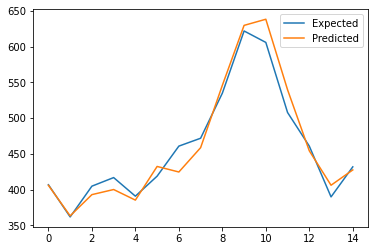

MAE: 13.961849


In [ ]:
from matplotlib import pyplot
pyplot.plot(Ytest[:,0], label='Expected')
pyplot.plot(predict[:,0], label='Predicted')
#pyplot.plot(Data.dat[:,0], label='orig train')
pyplot.legend()
pyplot.show()
mae = abs(Ytest[:,0] - predict[:,0]).mean()
print("MAE:", mae)

### TFT
Temporal Fusion Transformers (TFT)


"Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting"
Bryan Lim, Sercan O. Arık, Nicolas Loeffb, Tomas Pfister, Dec 2019 ([Paper](https://arxiv.org/abs/1912.09363.pdf))


![multi-horizon](https://storage.googleapis.com/groundai-web-prod/media/users/user_236644/project_402585/images/Schematic.png)


Compare to other models:
ARIMA, ETS, TRMF, DeepAR, DSSM, ConvTrans, Seq2Seq, MQRNN
- ETS (Error, Trend, Seasonal) method is an approach method for forecasting time series univariate. (https://otexts.com/fpp2/arima-ets.html)
- Deep State-Space Models (DSSM) [6] adopt a similar approach, utilizing LSTMs to generate parameters of a predefined linear state-space model with predictive distributions produced via Kalman filtering – with extensions for multivariate time series data in [21].
- Deep AR [9] which uses stacked LSTM layers to generate parameters of one-step-ahead Gaussian predictive distributions
- The Multi-horizon Quantile Recurrent Forecaster (MQRNN) [10] uses LSTM or convolutional encoders to generate context vectors which are fed into multi-layer perceptrons (MLPs) for each horizon.


In [11] a multi-modal attention mechanism is used with LSTM encoders to construct context vectors for a bi-directional LSTM decoder. Despite performing better than LSTM-based iterative methods, interpretability remains challenging for such standard direct methods.
(C. Fan, et al., Multi-horizon time series forecasting with temporal attention learning, 2019.)

By interpreting attention patterns, TFT can provide insightful explanations about temporal dynamics, and do so while maintaining state-ofthe-art performance on a variety of datasets.

![data](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/b941cb83f4aad597bf7ca72613d130c714d65d54/7-Table1-1.png)

Time Series Interpretability with Attention: 
- Attention mechanisms are used in translation [17], image classification [22] or tabular learning [23]
to identify salient portions of input for each instance using the magnitude of attention weights. 
- Recently, they have been adapted for time series with interpretability motivations [7, 12, 24], using LSTM-based [25] and transformer-based [12] architectures. However, this was done without considering the importance
of static covariates (as the above methods blend variables at each input). 
- TFT alleviates this by using separate encoder-decoder attention for static features at each time step on top of the self-attention to determine the contribution time-varying inputs.

Ref:
- https://arxiv.org/abs/1912.09363.pdf
- https://github.com/google-research/google-research/tree/master/tft
- https://github.com/louisyuzhe/deeplearning_forecast
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_forecasting

     |████████████████████████████████| 542kB 3.4MB/s 
     |████████████████████████████████| 276kB 18.8MB/s 
     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 829kB 19.2MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=a33ddd44a111408a22d04816007d162e022af48d75790b9c9ea50398f5984dc0
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=c23e52fd9aa5ec60e5647c37c969e4c8ba08a9d156fef39cbaab23ab802a0d09
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninst

In [ ]:
#https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

For this tutorial, we will use the Stallion dataset from Kaggle describing sales of various beverages. Our task is to make a six-month forecast of the sold volume by stock keeping units (SKU), that is products, sold by an agency, that is a store. There are about 21 000 monthly historic sales records. In addition to historic sales we have information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry.

In [ ]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

agency     sku  ...  avg_volume_by_sku avg_volume_by_agency
291    Agency_25  SKU_03  ...        1225.306376            99.650400
871    Agency_29  SKU_02  ...        1634.434615            11.397086
19532  Agency_47  SKU_01  ...        2625.472644            48.295650
2089   Agency_53  SKU_07  ...          38.529107          2511.035175
9755   Agency_17  SKU_02  ...        2143.677462           396.022140
7561   Agency_05  SKU_03  ...        1566.643589          1881.866367
19204  Agency_11  SKU_05  ...        1385.225478           109.699200
8781   Agency_48  SKU_04  ...        1757.950603          1925.272108
2540   Agency_07  SKU_21  ...           0.000000          2418.719550
12084  Agency_21  SKU_03  ...        2034.293024           109.381800

[10 rows x 31 columns]

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], coerce_positive=1.0
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.7k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

suggested learning rate: 5.888436553555889e-06


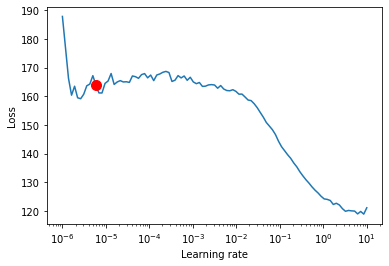

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



1

In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=10,#50
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)


[I 2020-10-27 23:32:56,698] A new study created in memory with name: no-name-e7e911d6-75fb-4778-aeab-54de27b6ba5e
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1 K   
3  | prescalers                         | ModuleDict                      | 928   
4  | static_variable_selection          | VariableSelectionNetwork        | 43 K  
5  | encoder_variable_selection         | VariableSelectionNetwork        | 98 K  
6  | decoder_variable_selection         | VariableSelectionNetwork        | 35 K  
7  | static_context_variable_selection  | GatedResidualNe

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(255.1261)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

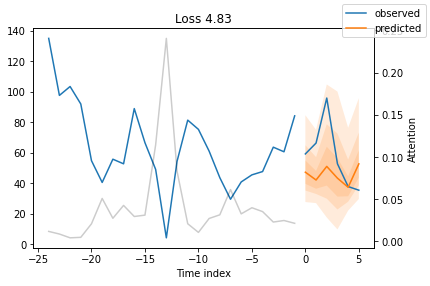

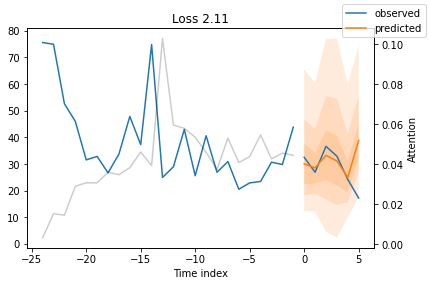

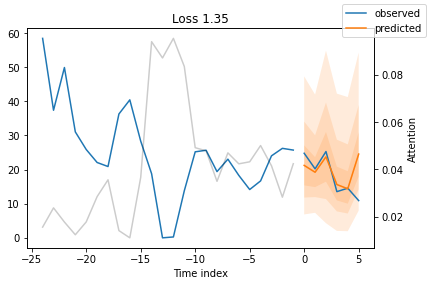

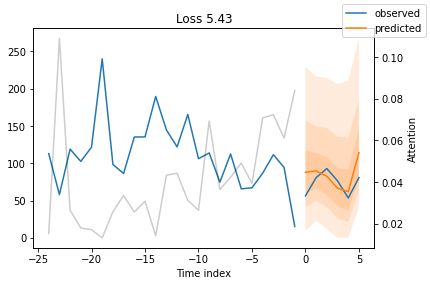

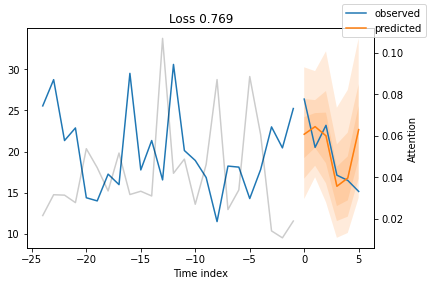

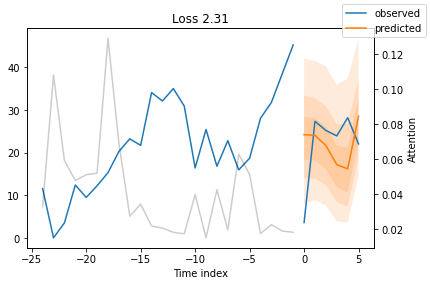

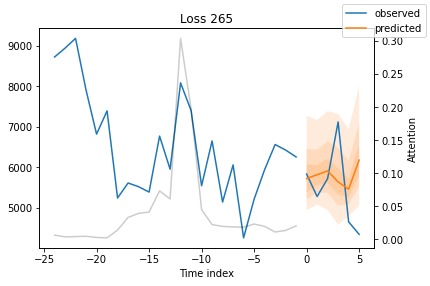

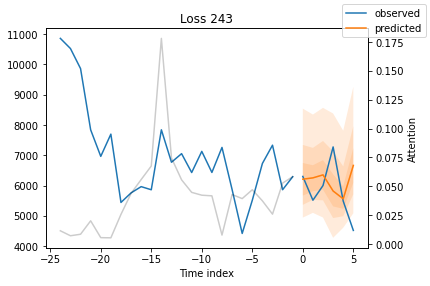

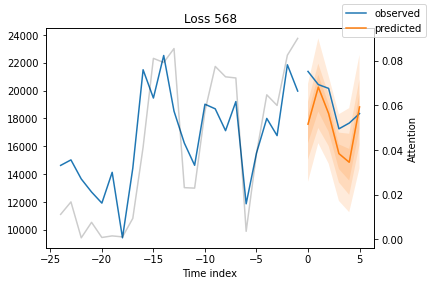

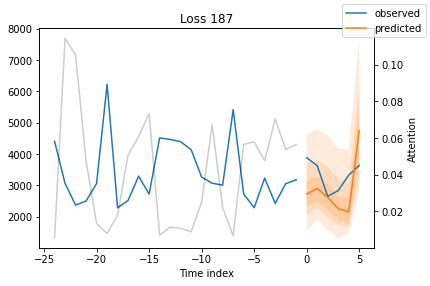

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

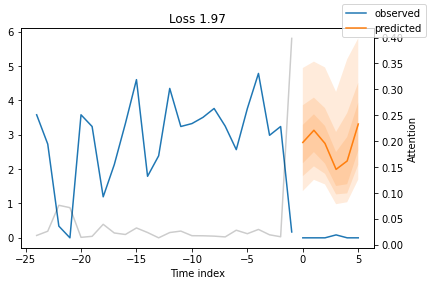

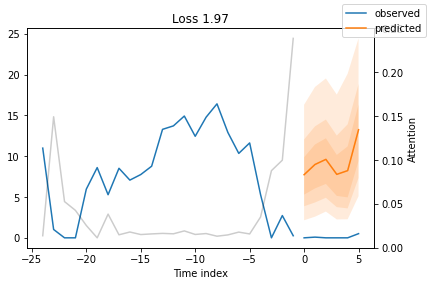

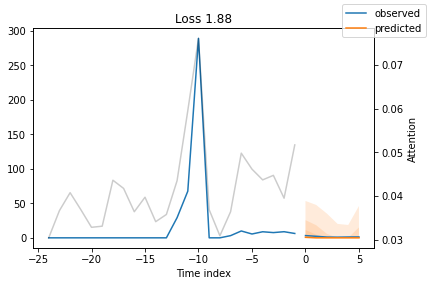

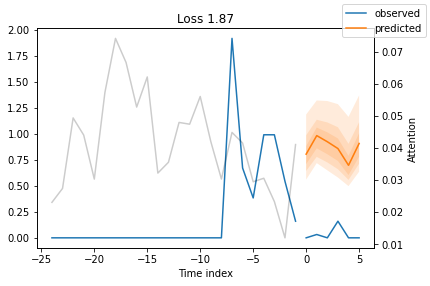

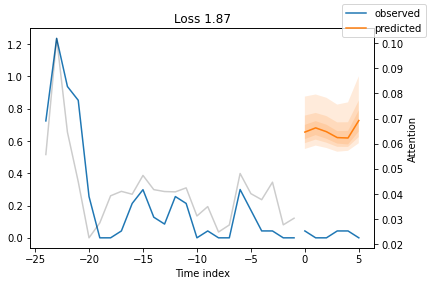

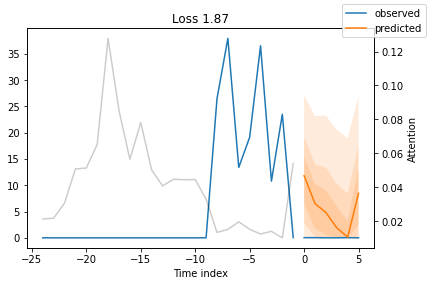

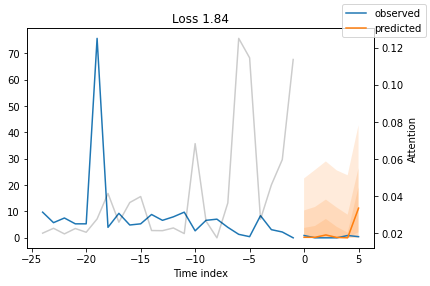

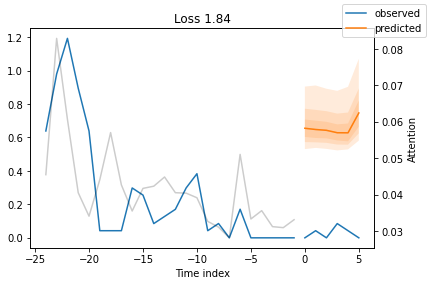

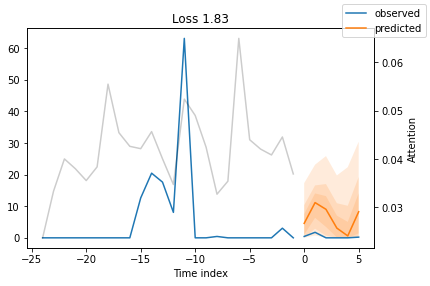

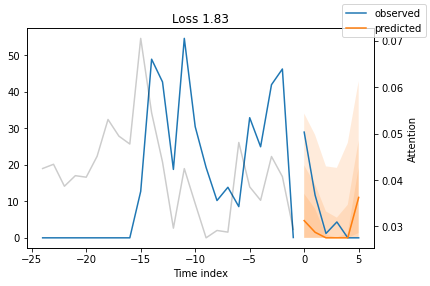

In [ ]:
# worst performer
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

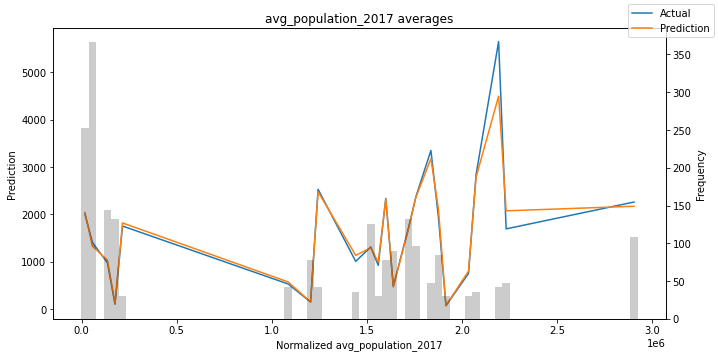

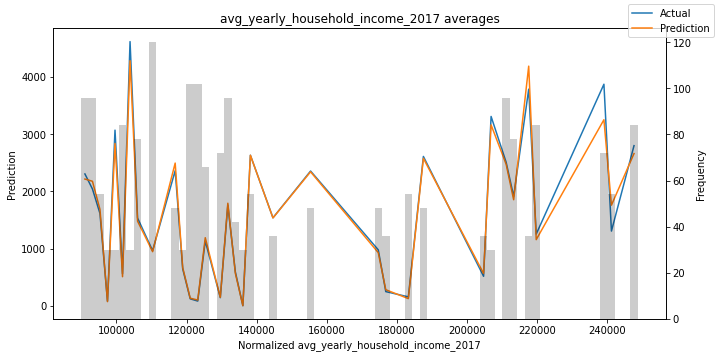

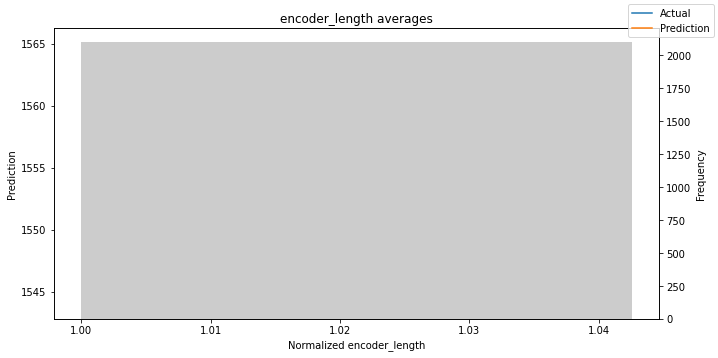

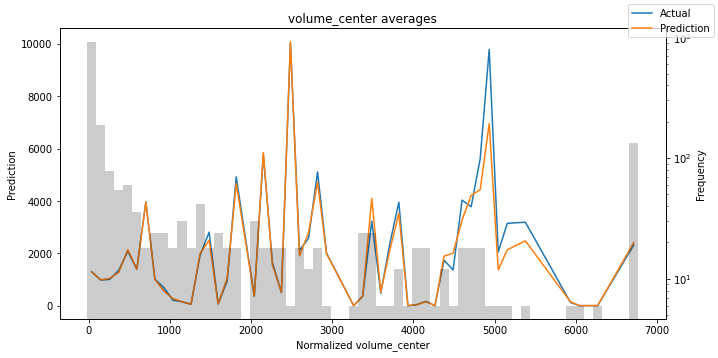

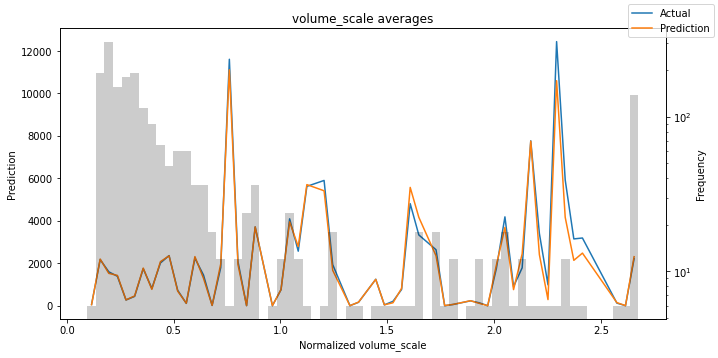

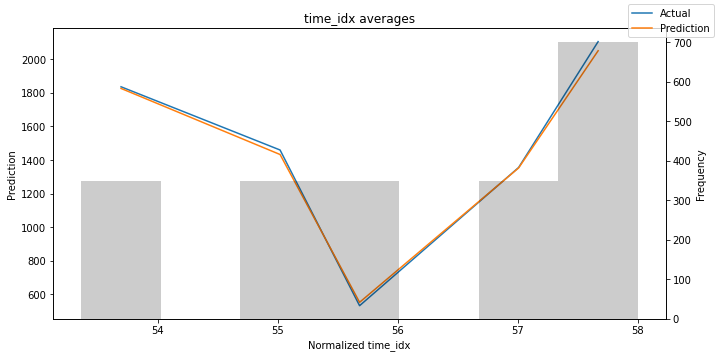

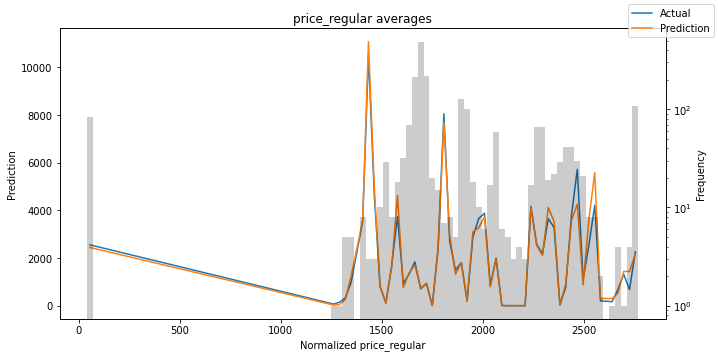

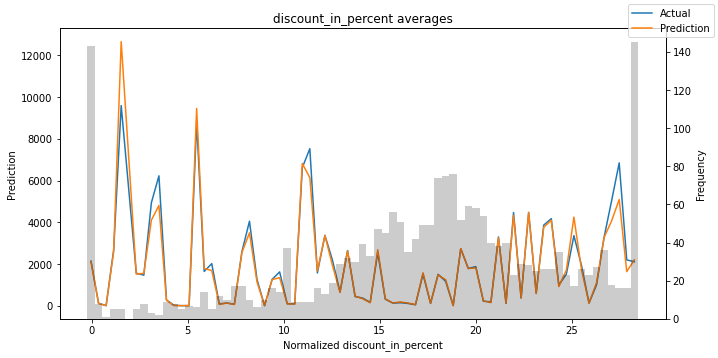

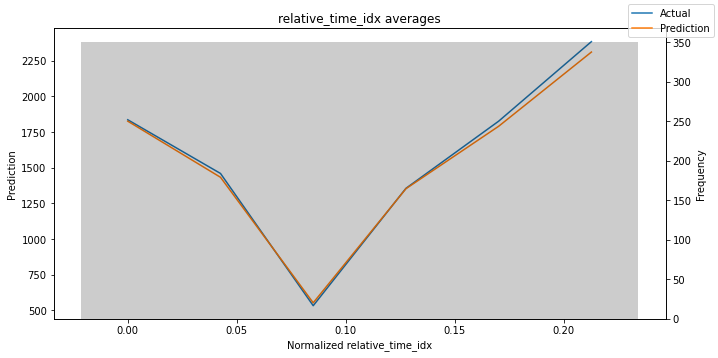

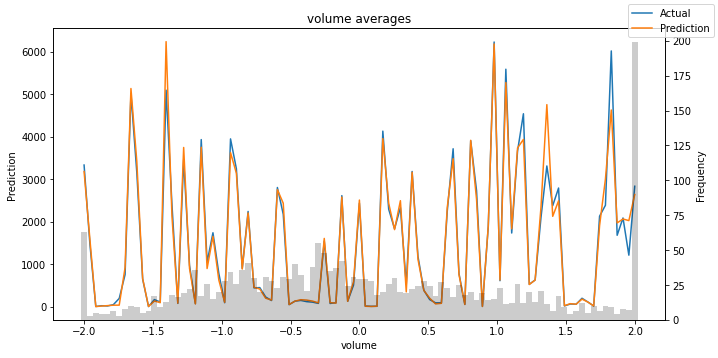

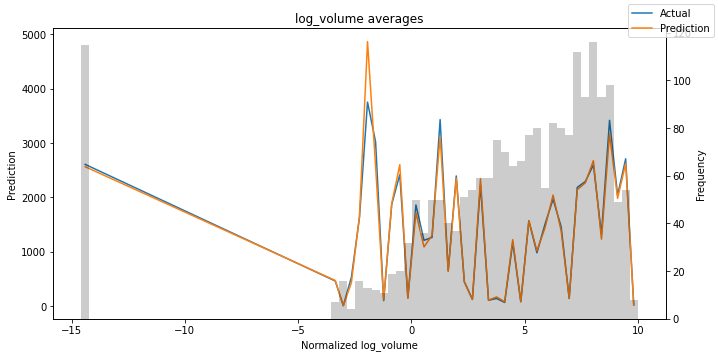

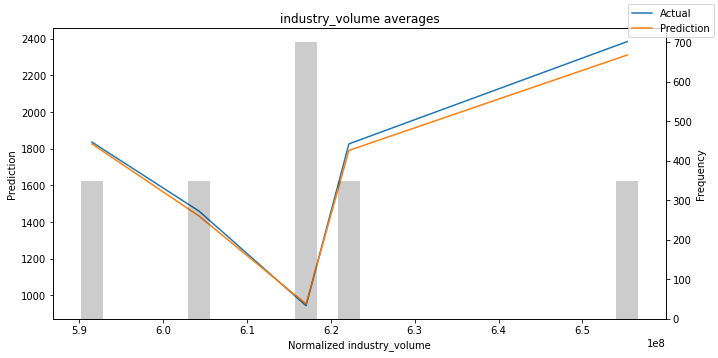

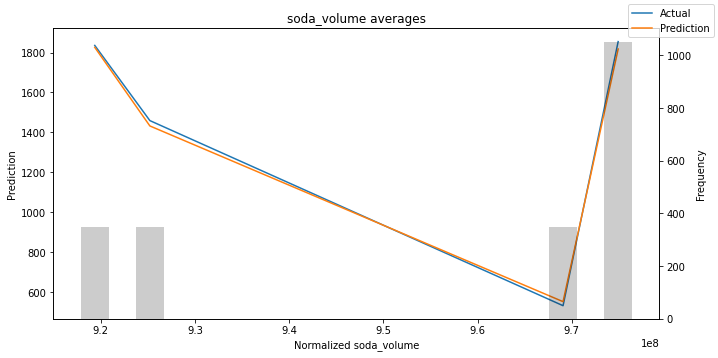

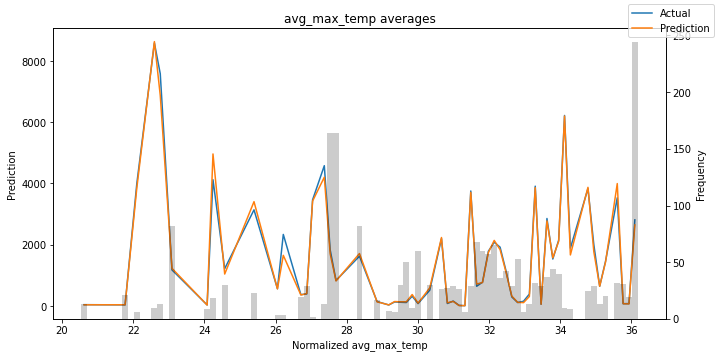

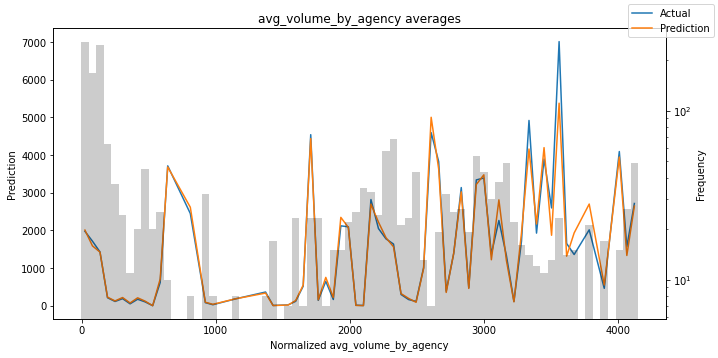

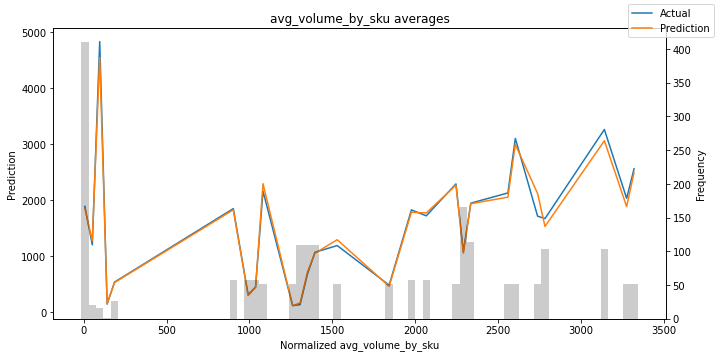

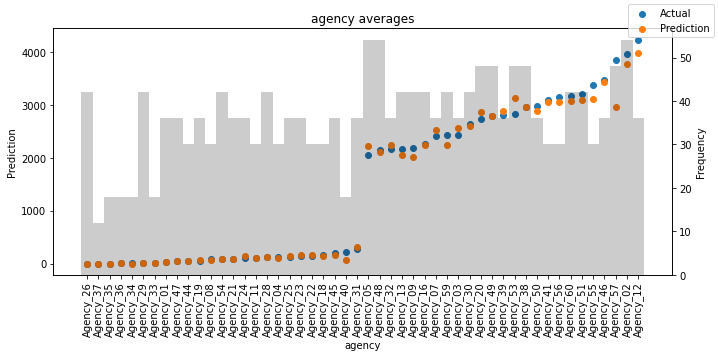

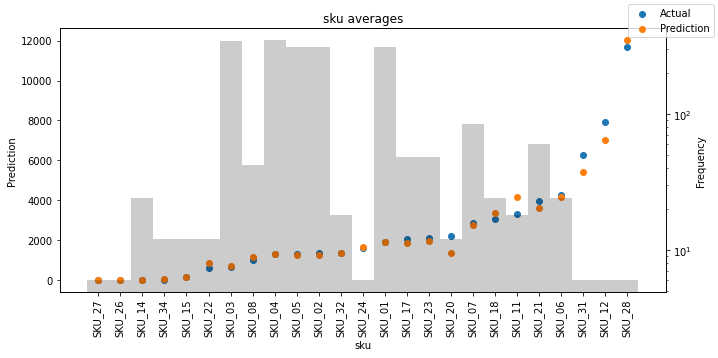

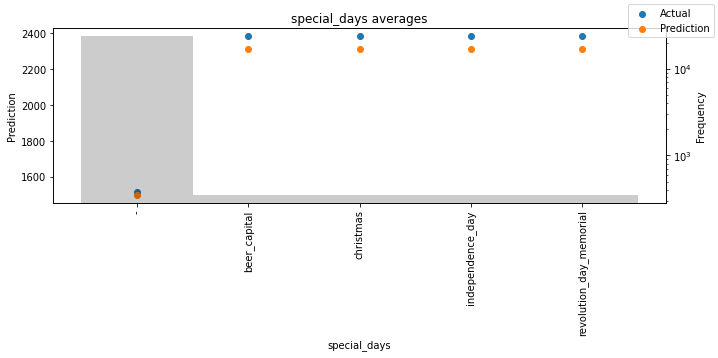

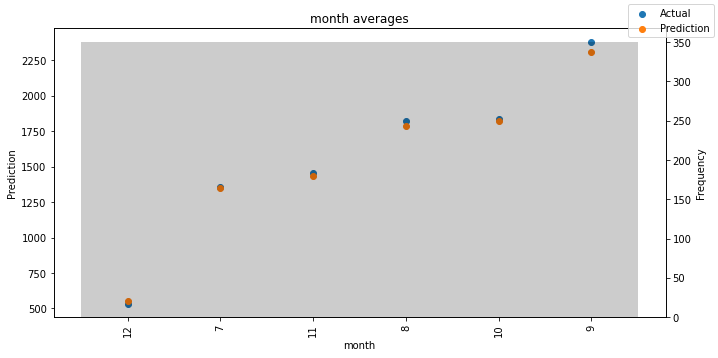

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
#prediction on new data
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

/usr/local/lib/python3.6/dist-packages/pytorch_forecasting/data/timeseries.py:674: UserWarning:

If predicting, no randomization should be possible - setting stop_randomization=True



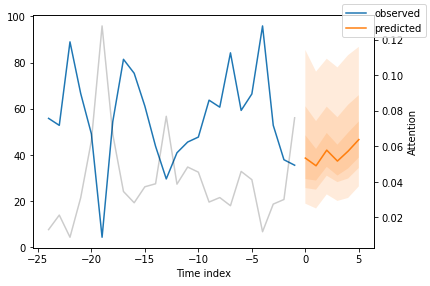

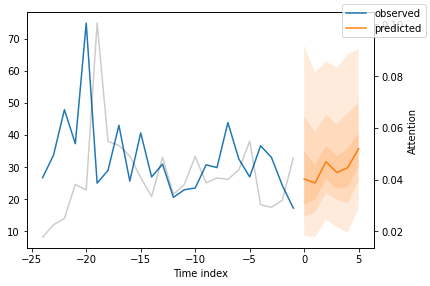

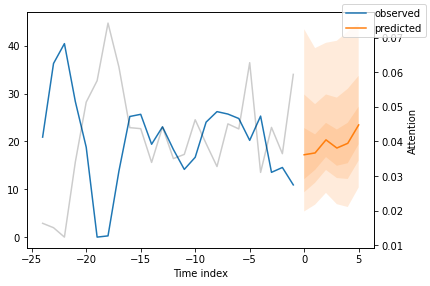

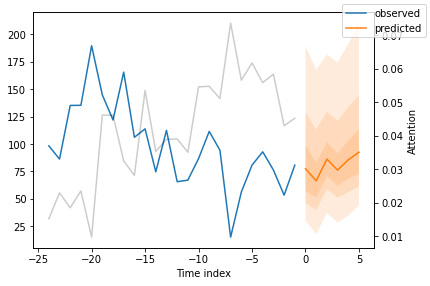

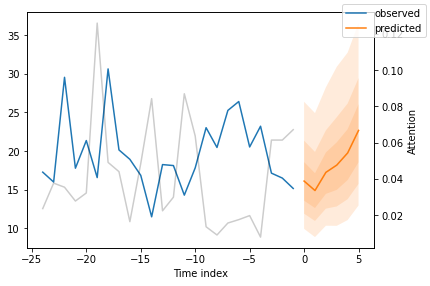

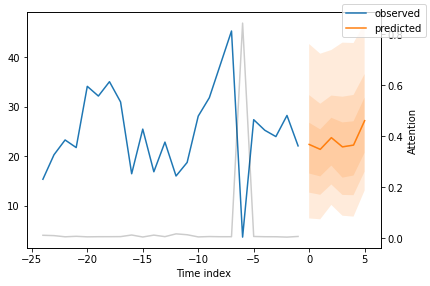

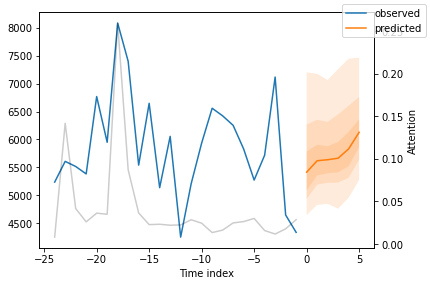

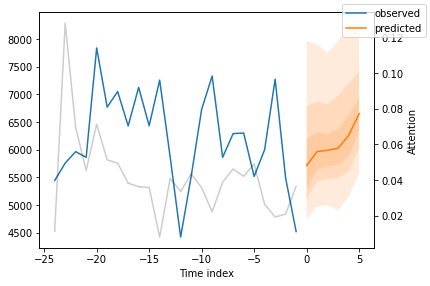

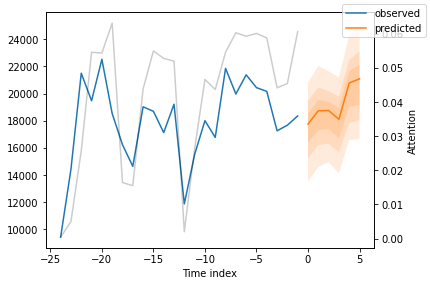

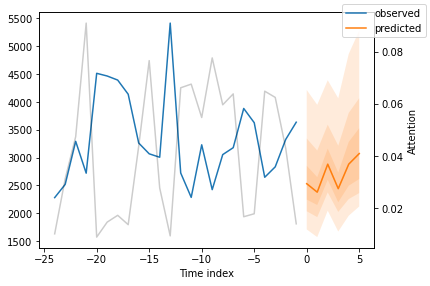

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw",return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>}

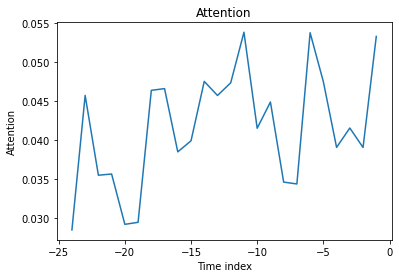

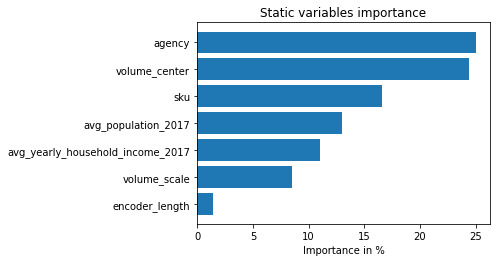

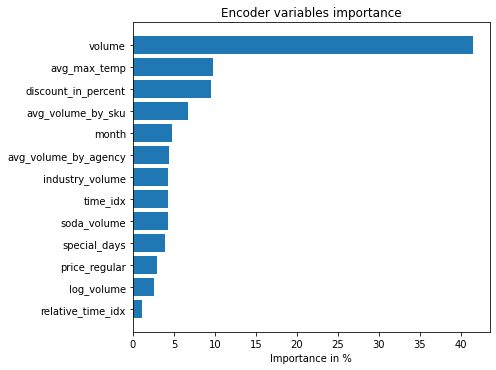

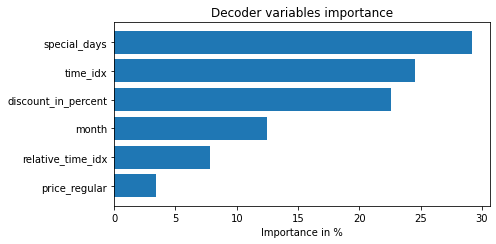

In [ ]:
# interpret model
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

### N-BEATS
Neural Basis Expansion Analysis for Interpretable Time Series (N-BEATS) (https://arxiv.org/abs/1905.10437)

"N-BEATS: Neural Basis Expansion Analysis for Interpretable Time Series Forecasting",
Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio, May 2019, ICLR 2020 (https://arxiv.org/abs/1905.10437)

Time Series Forecast for:
- multi-horizons
- multiple series
- interpretabilities: seasonality and trend

>"Pure DL using no time-series specific components outperforms well-established statistical approaches on M3, M4 and TOURISM datasets (on M4, by 11% over statistical benchmark, by 7% over the best statistical entry, and by 3% over the M4 competition winner)."

Architectural design:
- simple and generic, yet expressive (deep). 
- not rely on timeseries-specific feature engineering or input scaling for pure DL architecture in TS forecasting. 
- explore interpretability, extendable towards making its outputs human interpretable. 
![n-beats](https://d3i71xaburhd42.cloudfront.net/13c185b8c461034af2634f25dd8a85889e8ee135/3-Figure1-1.png)

Model types in the notations:
- I : interpretability
- G : general
- G+I : ensembles with I and G

Interpretabilities:
- Trend
- Seasonality
![n-beats](https://d3i71xaburhd42.cloudfront.net/13c185b8c461034af2634f25dd8a85889e8ee135/8-Figure2-1.png)

Performance: Compare to M4, M3 competition
![N-BEATS Performance](https://d3i71xaburhd42.cloudfront.net/13c185b8c461034af2634f25dd8a85889e8ee135/6-Table2-1.png)

Ref:
- Paper: https://arxiv.org/abs/1905.10437
- https://medium.com/@kshavgupta47/n-beats-neural-basis-expansion-analysis-for-interpretable-time-series-forecasting-91e94c830393
- https://github.com/philipperemy/n-beats

In [ ]:
!pip install pytorch_lightning
#deep copy issue with leaf node in latest 0.5.2 for N-BEATs, start 0.5.0 has N-Beats and TFT
!pip install pytorch_forecasting==0.5.0

     |████████████████████████████████| 563kB 3.4MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
     |████████████████████████████████| 829kB 9.8MB/s 
     |████████████████████████████████| 276kB 20.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=e30f49a80f50f731a4b4a3256d67e08d09272da2cda30df9e9232f7ab3e74d2c
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=7339a16293b0082742cc4abf897a88287e6d1fafbae9a5628d4aa6097e37397e
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unins

In [ ]:
#https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/ar.html

import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE


In [ ]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

series  time_idx     value  static       date
0       0         0 -0.000000       2 2020-01-01
1       0         1 -0.046501       2 2020-01-02
2       0         2 -0.097796       2 2020-01-03
3       0         3 -0.144397       2 2020-01-04
4       0         4 -0.177954       2 2020-01-05

In [ ]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff+1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [ ]:
# calculate baseline absolute error
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5462)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=1.0)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1 M   


suggested learning rate: 0.005623413251903493


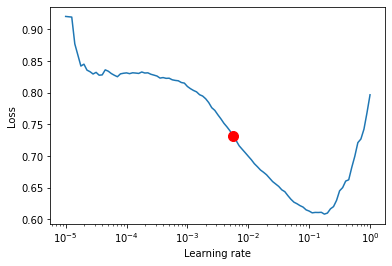

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(training, learning_rate=4e-3, log_interval=10, log_val_interval=1, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=1.0)

trainer.fit(
    net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1 M   


1

In [ ]:
#evaluate result
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()


tensor(0.1993)

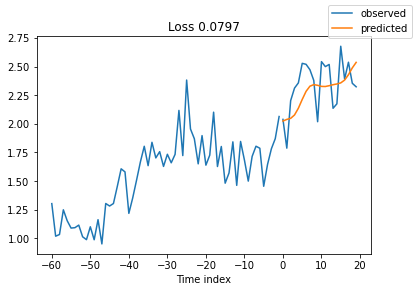

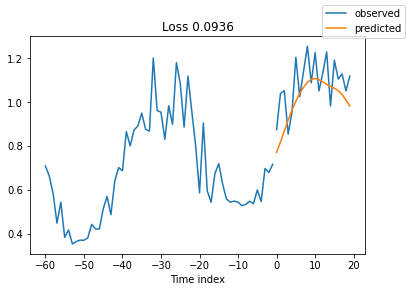

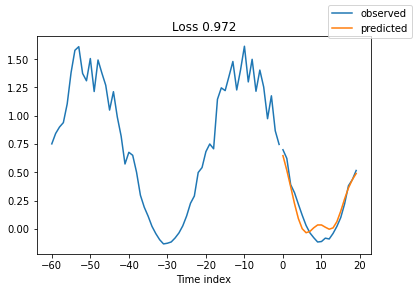

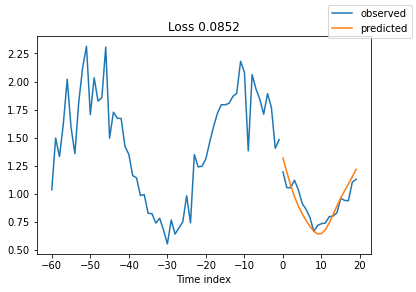

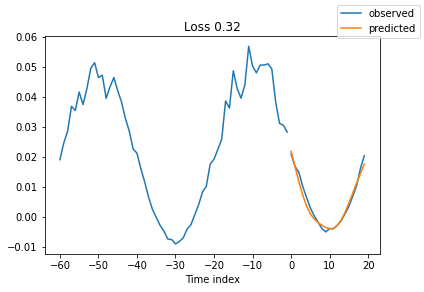

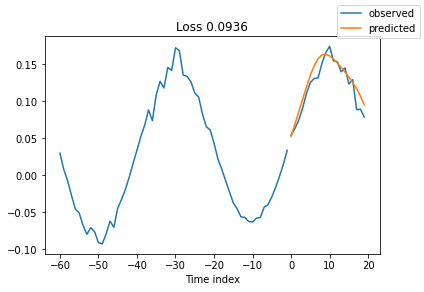

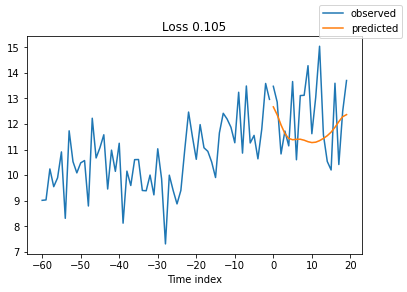

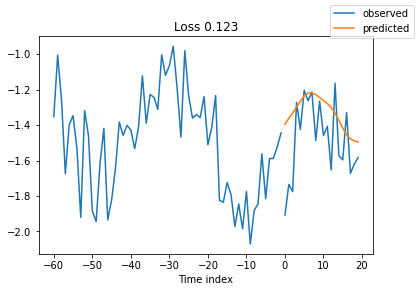

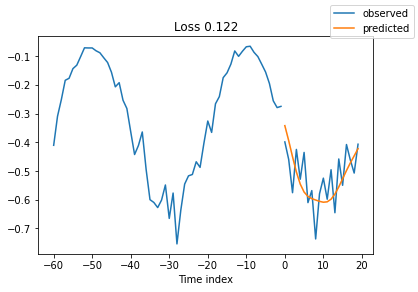

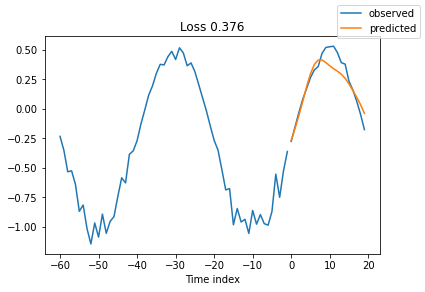

In [ ]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);


## Commercial Applications

### Facebook Prophet
Prophet is a modular regression
model with interpretable parameters that can be intuitively adjusted by analysts. It decomposed the series into three main model components: 
1. trend
2. seasonality
3. holidays

Use only time as a regressor but possibly several linear and non-linear functions of time as components. 

Has a number of advantages:
- Flexibility: We can easily accommodate seasonality with multiple periods
- Fitting is very fast
- Has easily interpretable parameters

Ref:
- Paper: https://peerj.com/preprints/3190/
- Code:  https://github.com/facebookincubator/prophet
- Tutorial: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3



In [8]:
!mkdir timeseries

In [9]:
!curl -O https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1748  100  1748    0     0   7375      0 --:--:-- --:--:-- --:--:--  7406


In [ ]:
!pip install pandas matplotlib numpy cython
!pip install pystan
!pip install fbprophet

#### Train

In [10]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [11]:
df = pd.read_csv('AirPassengers.csv')
df.head(5)

Month  AirPassengers
0  1949-01            112
1  1949-02            118
2  1949-03            132
3  1949-04            129
4  1949-05            121

In [12]:
df.dtypes

Month            object
AirPassengers     int64
dtype: object

In [13]:
df['Month'] = pd.DatetimeIndex(df['Month'])
df.dtypes

Month            datetime64[ns]
AirPassengers             int64
dtype: object

In [14]:
df.head(5)

Month  AirPassengers
0 1949-01-01            112
1 1949-02-01            118
2 1949-03-01            132
3 1949-04-01            129
4 1949-05-01            121

In [15]:
# don't rename Month --use for index, can't index ds, Prophet will complain
#df = df.rename(columns={'Month': 'ds','AirPassengers': 'y'})
df['ds']=df["Month"]
df = df.rename(columns={'AirPassengers': 'y'})
df.head(5) #1949-01 -> 1960-12

Month    y         ds
0 1949-01-01  112 1949-01-01
1 1949-02-01  118 1949-02-01
2 1949-03-01  132 1949-03-01
3 1949-04-01  129 1949-04-01
4 1949-05-01  121 1949-05-01

In [16]:
#df['ds'] = pd.DatetimeIndex(df['ds'])
#df.index #RangeIndex
df = df.set_index('Month') # don't set index on 'ds'
df.index #DateteimIndex
#df['1959':]

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [17]:
df.head()

y         ds
Month                     
1949-01-01  112 1949-01-01
1949-02-01  118 1949-02-01
1949-03-01  132 1949-03-01
1949-04-01  129 1949-04-01
1949-05-01  121 1949-05-01

In [18]:
train_data = df[:"1959"] #1949-01 -> 1959-12
print(train_data.index)
test_data = df["1960":] #1960-01 => 1960-12
print(test_data.index)
train_data.head(5)

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1959-03-01', '1959-04-01', '1959-05-01', '1959-06-01',
               '1959-07-01', '1959-08-01', '1959-09-01', '1959-10-01',
               '1959-11-01', '1959-12-01'],
              dtype='datetime64[ns]', name='Month', length=132, freq=None)
DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)


y         ds
Month                     
1949-01-01  112 1949-01-01
1949-02-01  118 1949-02-01
1949-03-01  132 1949-03-01
1949-04-01  129 1949-04-01
1949-05-01  121 1949-05-01

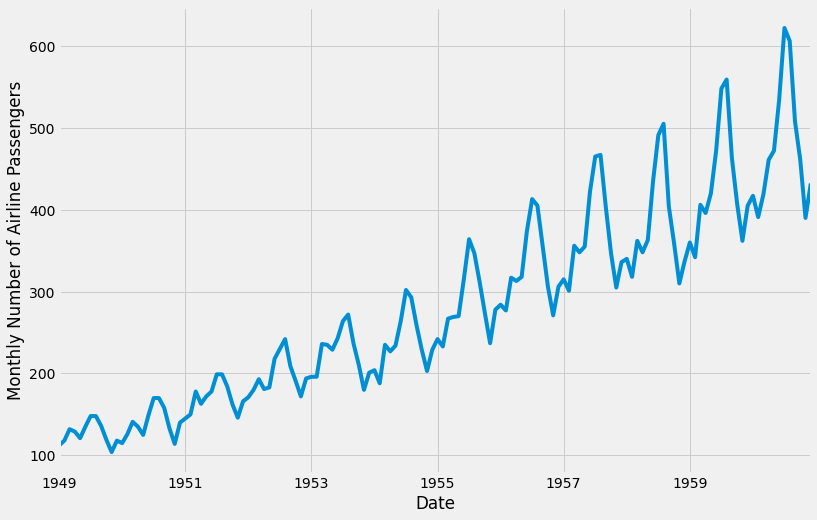

In [19]:
#df = df.set_index('ds') # done on top
ax = df['y'].plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

In [20]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.98, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True,)
my_model.fit(train_data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [21]:
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

ds
139 1960-08-01
140 1960-09-01
141 1960-10-01
142 1960-11-01
143 1960-12-01

#### Forecast and result

In [22]:
future_dates.head()

ds
0 1949-01-01
1 1949-02-01
2 1949-03-01
3 1949-04-01
4 1949-05-01

In [23]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
139 1960-08-01  524.361022  480.743703  566.594898
140 1960-09-01  485.319957  435.769775  532.657771
141 1960-10-01  452.658227  406.493989  501.254545
142 1960-11-01  423.892925  375.248677  467.046453
143 1960-12-01  446.588198  397.718138  495.228064

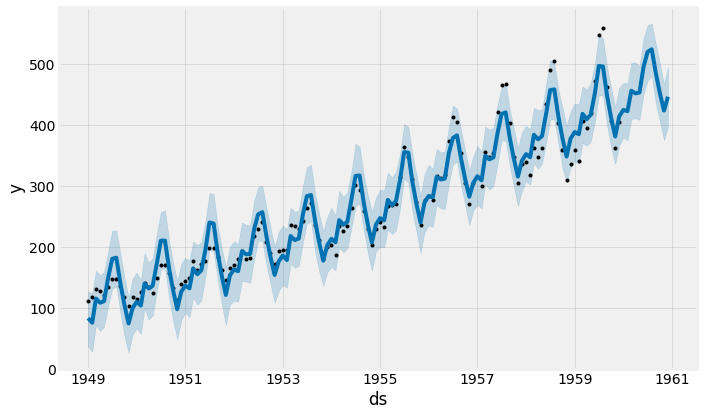

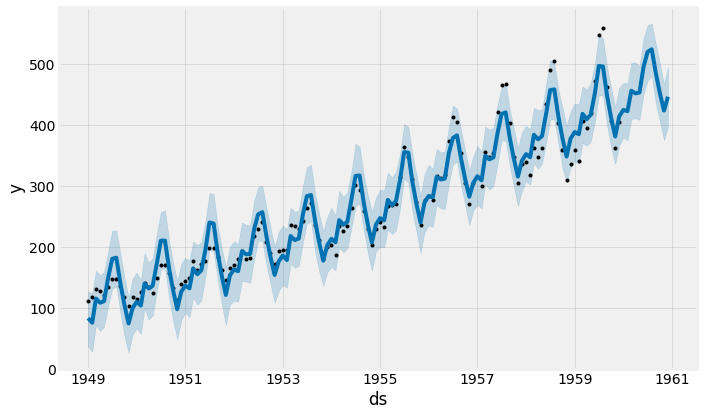

In [24]:
my_model.plot(forecast, uncertainty=True)

Then compare to ARIMA - in the other notebook 

RMSE=90

In [25]:
pd.options.mode.chained_assignment = None  # default='warn' supress warning

yhat = forecast[-12:]["yhat"]
test_data["yhat"] = yhat[0:12].to_numpy()
test_data['yhat_lower'] = forecast[-12:][['yhat_lower']].to_numpy()
test_data['yhat_upper'] = forecast[-12:][['yhat_upper']].to_numpy()

mae = abs(test_data["y"] - test_data["yhat"]).mean()
print("MAE:", mae) #33.91 vs 19.5 (ARIMA)

MAE: 33.91755993316479


In [26]:
import numpy as np
MSE = ((test_data["y"] - test_data["yhat"])**2).mean()
RMSE = np.sqrt(MSE)
print("RMSE:", RMSE)

RMSE: 44.19293967508108


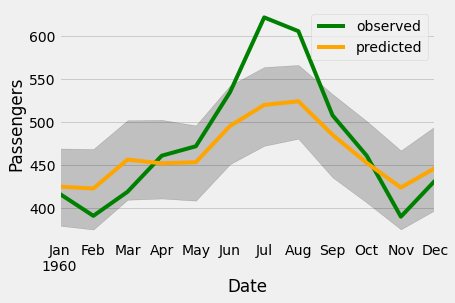

In [27]:
ax = test_data['y'].plot(label='observed', color='green')
ax = test_data['yhat'].plot(label='predicted', color='orange')
#ax = test_data['yhat_lower'].plot(label='yhat_lower', color="gray")
#ax = test_data['yhat_upper'].plot(label='yhat_upper', color="gray")
ax.fill_between(test_data.index,
                test_data['yhat_lower'],
                test_data['yhat_upper'], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()

plt.show()

In [28]:
test_data

y         ds        yhat  yhat_lower  yhat_upper
Month                                                         
1960-01-01  417 1960-01-01  424.995013  379.600922  469.391969
1960-02-01  391 1960-02-01  422.841556  375.087119  468.753033
1960-03-01  419 1960-03-01  456.425111  409.710117  502.240223
1960-04-01  461 1960-04-01  452.106635  411.205530  502.716570
1960-05-01  472 1960-05-01  453.466585  408.682826  496.217851
1960-06-01  535 1960-06-01  495.705076  451.209033  542.741381
1960-07-01  622 1960-07-01  520.114582  472.553461  564.169575
1960-08-01  606 1960-08-01  524.361022  480.743703  566.594898
1960-09-01  508 1960-09-01  485.319957  435.769775  532.657771
1960-10-01  461 1960-10-01  452.658227  406.493989  501.254545
1960-11-01  390 1960-11-01  423.892925  375.248677  467.046453
1960-12-01  432 1960-12-01  446.588198  397.718138  495.228064

In [29]:
forecast.head()

ds       trend  ...  multiplicative_terms_upper        yhat
0 1949-01-01  108.446107  ...                         0.0   83.721210
1 1949-02-01  110.624181  ...                         0.0   76.241626
2 1949-03-01  112.591474  ...                         0.0  115.696885
3 1949-04-01  114.769548  ...                         0.0  109.000900
4 1949-05-01  116.877362  ...                         0.0  111.497871

[5 rows x 16 columns]

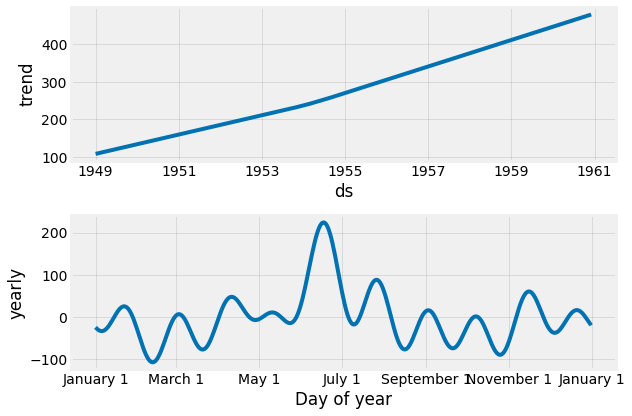

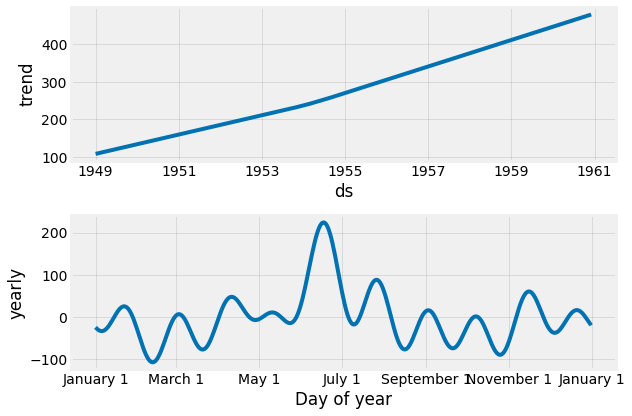

In [30]:
my_model.plot_components(forecast)


### Amazon DeepAR

"DeepAR, a forecasting method based on autoregressive recurrent networks, which learns such a global model from historical data of all time series in the data set." It uses a similar LSTM-based recurrent neural network architecture. This only run on Amazon Sagemaker but there is an implimentation in pytorch in the link below.

Classical Techniques Problem:
 - there is a need for forecasting thousands or millions of related time series
 - Examples: forecasting forecasting the load for servers in a data center, or forecasting the demand for all products of a large retailer 
 - related time series can be leveraged for making a forecast for an individual time series. 
 - allows fitting more complex (and hence potentially more accurate) models without overfitting
 - eliminate manual feature engineering and model selection steps

Features:
- the model learns seasonal behavior and
dependencies on given covariates across time series
- by learning from similar items, it can provide forecasts for items with little or no history at all

Ref:
- DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks
https://arxiv.org/abs/1704.04110
- https://towardsdatascience.com/prophet-vs-deepar-forecasting-food-demand-2fdebfb8d282
- Implementation in pytorch
https://github.com/zhykoties/TimeSeries



## Conclusion

Time series fit well with structural approach such as ARIMA which give the interpretability with trend and seasonality. Exponential smoothing such as Holt-Winters can give a similar approach. 

Then in machine learning approach, required the input to be format into features. The typical linear regression is not that bad. XGBoost was used in Kaggle competition winner. 

In deep learning, the sequence to sequence approach like RNN and LSTM does shows some promise. New architure start to emerge just beyond CNN and RNN. TCN, LSTNet showed great performance surpase ARIMA. 

Then TFT and N-BEATS are the lastest approaches that are the current state of the arts. They outperformed previous approaches and winner in the M4 competition.
